# How to Build a Machine Learning Model for Chemical Property Prediction

> This notebook shows how to build a simple but strong machine-learning model for the prediction of **logP** (water-octanol partition coefficient).
- toc: True
- metadata_key1: QSPR
- metadata_key2: logP
- metadata_key3: machine learning

This notebook shows how to build a simple but strong machine-learning model for the prediction of **logP** (octanol-water partition coefficient). 

  The **logP** is quite an important property in medicinal and pharmaceutical chemistry, as it relates to the distribution of drugs between aqueous phases (hydrophilic phases such as blood) and other non-aqueous compartments in the human body.

The approach is tested on the recent **SAMPL7 blind challenge** dataset showing excellent results here.

In fact this approach can be used to predict any chemical property as long as their
is enough chemical data for model building, i.e. in the form of several hundred or better thousands SMILES and property pairs.  

**Never** use this approach for small datasets, i.e. use at least a few 100 samples if possible. That is a common mistake i.e. using the machinery of ML on small datasets without doing the due diligent statistics - paving the way for "predictive" models being much to over-confident, which look great in theory and academic papers but failing terribly in real-world practice!

## Used libraries:

* [RDKit](https://www.rdkit.org/)
* [lightgbm](https://lightgbm.readthedocs.io/en/latest/)
* [pandas](https://pandas.pydata.org/)
* [scikit-learn](https://scikit-learn.org/stable/)

## Used data:

* [Opera curated physprop dataset(s)](https://epa.figshare.com/articles/dataset/PHYSPROP_Analysis_File_12_14_2016/5588578/2)
* [SAMPL7 logP blind challenge data](https://github.com/samplchallenges/SAMPL7)

# Overview & individual steps

1. [Load experimental data](#Loading-the-data)
2. [Compute descriptors](#Computing-descriptors)
3. [Compute fingerprints](#Computing-fingerprints-as-descriptors)
4. [Model building](#Model-training)
5. [Parameter selection](#Parameter-selection)
6. [Deployment & Analysis](#Deployment-&-Analysis-of-the-results)

### First loading all needed python libraries

In [1]:
# technical & general libraries
from tqdm.notebook import tqdm

# data science libraries
import pandas as pd
import lightgbm as lgb

from sklearn.model_selection import KFold,cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

from joblib import dump, load

# cheminformatics
from rdkit.Chem import AllChem as Chem
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

# set some options for better visibility of DataFrames
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

## Loading the data

We start with loading training and test set data from [SD files](https://en.wikipedia.org/wiki/Chemical_table_file). Those files contain the molecular structure and the corresponding chemical property, here the logP value. The data can be found as an updated version [here](https://github.com/kmansouri/OPERA) and the original published data [here](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0263-1#Sec23).
We use a built-in library from RDKit to create a list of molecules and logP value pairs from it, in total more than 10000 samples.  

Those pairs are saved in a list of dictionaries which can then be used to create a pandas DataFrame from it.
This DataFrame is a very useful data structure which allows easy handling of tabular data.  

For now we use only the provided training data, there is also another SD file with test data, which we leave aside completety for now and which could be used later on to finally test the results.

Lets start with downloading and unzipping the data from the source:

In [2]:
!wget -O ./opera_data.zip https://ndownloader.figstatic.com/files/10692997
#wget -O ./opera_data.zip https://github.com/kmansouri/OPERA/blob/master/OPERA_Data.zip?raw=true # github data
!unzip ./opera_data.zip

--2020-11-21 20:26:44--  https://ndownloader.figstatic.com/files/10692997
Resolving ndownloader.figstatic.com (ndownloader.figstatic.com)... 34.246.107.109, 34.246.25.17
Connecting to ndownloader.figstatic.com (ndownloader.figstatic.com)|34.246.107.109|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pstorage-npg-968563215/10692997/13321_2018_263_MOESM1_ESM.zip [following]
--2020-11-21 20:26:44--  https://s3-eu-west-1.amazonaws.com/pstorage-npg-968563215/10692997/13321_2018_263_MOESM1_ESM.zip
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.96.114
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.96.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15303706 (15M) [binary/octet-stream]
Saving to: ‘./opera_data.zip’

./opera_data.zip    100%[===================>]  14.59M  1.29MB/s    in 16s     

2020-11-21 20:27:01 (911 KB/s) - ‘./opera_data.

We start with creating a DataFrame from the downloaded SD file.   
We ignore for now also some error message coming from parsing the molecular structures.

In [4]:
sd_file = './OPERA_LogP/TR_LogP_10537.sdf'
#sd_file = './LogP_QR.sdf' # github data
suppl = Chem.SDMolSupplier(sd_file)
data = []
for m in tqdm(suppl):
    if m is None: continue
    smiles = Chem.MolToSmiles(m)
    data.append({'SMILES': smiles, 'logP': m.GetProp('LogP')})

df = pd.DataFrame(data) 
df['logP'] = df['logP'].astype(float) # convert from string to float
df

RDKit ERROR: [20:27:13] ERROR: Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [20:27:17] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [20:27:17] ERROR: Could not sanitize molecule ending on line 146438
RDKit ERROR: [20:27:17] ERROR: Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [20:27:17] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [20:27:17] ERROR: Could not sanitize molecule ending on line 233170
RDKit ERROR: [20:27:17] ERROR: Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [20:27:17] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [20:27:17] ERROR: Could not sanitize molecule ending on line 400722
RDKit ERROR: [20:27:17] ERROR: Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [20:27:17] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [20:27:17] ERROR: Could not 

,SMILES,logP
0,C=O,0.35
1,CC1CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O)C(=O)CO,1.83
2,CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3C(O)CC21C,2.19
3,CCC1(c2ccccc2)C(=O)NC(=O)NC1=O,1.47
4,COC12C(COC(N)=O)C3=C(C(=O)C(C)=C(N)C3=O)N1CC1NC12,-0.40
...,...,...
10522,Brc1ccc(Oc2ccc(Br)c(Br)c2Br)c(Br)c1,7.37
10523,Brc1ccc(Oc2cc(Br)c(Br)cc2Br)c(Br)c1,7.32
10524,Brc1ccc(Oc2c(Br)cc(Br)cc2Br)c(Br)c1,7.24
10525,Brc1cc(Br)c(Oc2cc(Br)c(Br)cc2Br)c(Br)c1,7.82


Now we have a pandas DataFrame with SMILES, encoding the molecular topology, and experimental logP values.

## Computing descriptors

RDKit provides a nice tool to compute any kind of descriptors:

In [5]:
calculator = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
calculator.GetDescriptorNames()

('MaxEStateIndex',
 'MinEStateIndex',
 'MaxAbsEStateIndex',
 'MinAbsEStateIndex',
 'qed',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'NumRadicalElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VSA7',
 'SMR_VSA8',
 'SMR_VSA9',
 'SlogP_VSA1',
 'SlogP_VSA10',
 'SlogP_VSA11',
 'SlogP_VSA12',
 'SlogP_VSA2',
 'SlogP_VSA3',
 'SlogP_VSA4',
 'SlogP_V

Lets understand how the descriptor calculator from RDKit works.  
It takes a molecule and returns a `tuple` 
of all RDKit descriptors for this molecule, 200 in total.

In [6]:
calculator.CalcDescriptors??

In [7]:
len(calculator.CalcDescriptors(Chem.MolFromSmiles("CCO")))

200

In [8]:
def smiles2desc(s):
    descriptors = calculator.CalcDescriptors(Chem.MolFromSmiles(s))
    return descriptors

Lets first create a pandas series and then turn this (pandas) series of tuples into a pandas DataFrame containing all descriptors. This might take a while...   
Certainly we do not need all of those descriptors. Later we will find a way to select the descriptors we need.

We then save the DataFrame for later use and save some time during model development. By the way with the `%%time` command the cpu and wall times for running the code in a jupyter cell can be measured.

In [9]:
%%time
desc_tuples = df['SMILES'].apply(smiles2desc)
X = pd.DataFrame(desc_tuples.tolist(), columns = calculator.GetDescriptorNames())
X

CPU times: user 1min 11s, sys: 1.4 s, total: 1min 12s
Wall time: 1min 11s


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,8.000000,2.000000,8.000000,2.000000,0.360624,30.026,28.010,30.010565,12,0,0.106382,-0.307097,0.307097,0.106382,1.500000,1.500000,1.500000,2.000000,2.000000,2.000000,1.115355,1.115355,1.000000,0.288675,0.288675,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.33,2.000000e+00,1.670000,0.670000,-5.360303,12.900773,4.794537,6.789076,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,4.794537,6.789076,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,6.789076,4.794537,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,17.07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.789076,0.000000,4.794537,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,-0.1849,7.1210,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,16.859063,-1.980464,16.859063,0.067556,0.667213,392.467,363.235,392.199902,154,0,0.189906,-0.389712,0.389712,0.189906,1.321429,2.000000,2.642857,1.837692,804.748825,20.698306,16.613088,16.613088,12.963233,10.142335,10.142335,9.749151,9.749151,8.791253,8.791253,7.261033,7.261033,-1.37,1.500076e+06,19.925309,5.832748,2.014264,163.871786,15.319582,12.207933,17.235250,0.000000,0.0,0.000000,9.589074,4.390415,0.0,0.0,25.496599,56.594876,16.747887,6.103966,29.299072,11.566490,0.0,0.000000,28.583699,63.828275,6.606882,23.801165,0.0,0.000000,0.000000,4.390415,0.000000,0.000000,50.866731,9.589074

In [10]:
X.to_csv('tmp.csv',index=False)

## Computing circular fingerprints as descriptors

This step is optional - you can also directly proceed to the [model training](#Model-training).
For comparison lets also use Morgan fingerprints /[ECFP](https://pubs.acs.org/doi/10.1021/ci100050t) as descriptors.   There is some nice overview on different fingerprints also in this [presentation](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf).

Here also RDKit provides some nice function for fingerprint generation, lets understand how they work:

In [11]:
Chem.GetMorganFingerprintAsBitVect??
n_bits = 2048
fp = Chem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles("CCO"),2,nBits=n_bits)

In [12]:
def smiles2fingerprints(s):
    fp = Chem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s),2,nBits=n_bits)
    return [int(x) for x in fp.ToBitString()]

In [13]:
%%time
fp_tuples = df['SMILES'].apply(smiles2fingerprints)

CPU times: user 3.97 s, sys: 56 ms, total: 4.03 s
Wall time: 4.02 s


In [14]:
fp_names = ['fp'+str(i) for i in range(n_bits)]
X_fp = pd.DataFrame(fp_tuples.tolist(), columns = fp_names)
X_fp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10527 entries, 0 to 10526
Columns: 2048 entries, fp0 to fp2047
dtypes: int64(2048)
memory usage: 164.5 MB


In [15]:
X_fp.to_csv('tmp_fp.csv',index=False)

In case we want to use fingerprints instead as descriptors, just load the `tmp_fp.csv` dataframe now instead of the `tmp.csv`.

In [16]:
X = pd.read_csv('tmp.csv')
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10527 entries, 0 to 10526
Columns: 200 entries, MaxEStateIndex to fr_urea
dtypes: float64(96), int64(104)
memory usage: 16.1 MB


In [17]:
y = df.logP

Check if we have still the correct dimensions for the train data and the target data.

In [18]:
assert(X.shape[0]==len(y))

## Model training

Lets prepare the training. We are using the [lightgbm](https://lightgbm.readthedocs.io/en/latest/) library, which uses [stochastic gradient boosting](https://www.sciencedirect.com/science/article/abs/pii/S0167947301000652) for model building, which is currently the most effective way to train tabular data like this.    
There are several libraries for this, another quite commonly used library is [XGBoost](https://xgboost.readthedocs.io/en/latest/get_started.html).   

There are a lot of parameters to tune. We only use the most important ones. You can find more info on the parameters to choose on the [LightGBM homepage](https://lightgbm.readthedocs.io/en/latest/Parameters.html).


We use an 80/20 split for train and validation set. The validation is kept aside and with the training set we perform a 5-fold cross-validation.


In [19]:
lgb_params = {'num_leaves': 128,
                  'min_child_samples': 79,
                  'objective': 'regression',
                  'max_depth': 15,
                  'learning_rate': 0.01,
                  "boosting_type": "gbdt",
                  "subsample_freq": 1,
                  "subsample": 0.5,
                  "bagging_seed": 11,
                  "metric": 'mae',
                  "verbosity": -1,
                  'reg_alpha': 0.1,
                  'reg_lambda': 0.3,
                  'colsample_bytree': 1.0,
                  'n_estimators': 4000,
                  'n_jobs': -1,
                  }

model = lgb.LGBMRegressor(**lgb_params)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)
print(Xtrain.shape)
print(Xval.shape)

(8421, 200)
(2106, 200)


Now we actually fit the model, this also may take a while. You can adjust the `n_jobs` parameter to improve performance. You may also change the `verbosity` parameter in order to get more feedback during the calculation. 

Lets also remove some of the features. We do this by looking at the feature importance. There are more advanced methods for feature selection but for the sake of brevity we just use this. For simplicity we also use the API of lightgbm itself.

In [20]:
model.fit(Xtrain, ytrain, early_stopping_rounds=100,eval_metric=['l1'], eval_set=[(Xtrain, ytrain), (Xval, yval)])

[1]	training's l1: 1.39573	valid_1's l1: 1.39485
Training until validation scores don't improve for 100 rounds
[2]	training's l1: 1.38443	valid_1's l1: 1.38401
[3]	training's l1: 1.37321	valid_1's l1: 1.37319
[4]	training's l1: 1.36227	valid_1's l1: 1.36262
[5]	training's l1: 1.35132	valid_1's l1: 1.35197
[6]	training's l1: 1.34048	valid_1's l1: 1.34145
[7]	training's l1: 1.32992	valid_1's l1: 1.33103
[8]	training's l1: 1.31935	valid_1's l1: 1.32072
[9]	training's l1: 1.30899	valid_1's l1: 1.31065
[10]	training's l1: 1.29877	valid_1's l1: 1.30058
[11]	training's l1: 1.28868	valid_1's l1: 1.29074
[12]	training's l1: 1.27864	valid_1's l1: 1.28094
[13]	training's l1: 1.26866	valid_1's l1: 1.27118
[14]	training's l1: 1.25881	valid_1's l1: 1.26167
[15]	training's l1: 1.24923	valid_1's l1: 1.25228
[16]	training's l1: 1.23963	valid_1's l1: 1.24285
[17]	training's l1: 1.23002	valid_1's l1: 1.23362
[18]	training's l1: 1.22072	valid_1's l1: 1.22453
[19]	training's l1: 1.21138	valid_1's l1: 1.215

[167]	training's l1: 0.578882	valid_1's l1: 0.602392
[168]	training's l1: 0.577223	valid_1's l1: 0.600735
[169]	training's l1: 0.575699	valid_1's l1: 0.59925
[170]	training's l1: 0.574154	valid_1's l1: 0.597946
[171]	training's l1: 0.572593	valid_1's l1: 0.596476
[172]	training's l1: 0.571079	valid_1's l1: 0.595206
[173]	training's l1: 0.569536	valid_1's l1: 0.593846
[174]	training's l1: 0.568112	valid_1's l1: 0.592534
[175]	training's l1: 0.566543	valid_1's l1: 0.591104
[176]	training's l1: 0.565169	valid_1's l1: 0.589795
[177]	training's l1: 0.56372	valid_1's l1: 0.588538
[178]	training's l1: 0.562249	valid_1's l1: 0.587172
[179]	training's l1: 0.560878	valid_1's l1: 0.585982
[180]	training's l1: 0.559529	valid_1's l1: 0.584754
[181]	training's l1: 0.558165	valid_1's l1: 0.583594
[182]	training's l1: 0.556822	valid_1's l1: 0.58239
[183]	training's l1: 0.555527	valid_1's l1: 0.581253
[184]	training's l1: 0.554131	valid_1's l1: 0.579945
[185]	training's l1: 0.552846	valid_1's l1: 0.578

[323]	training's l1: 0.440218	valid_1's l1: 0.483183
[324]	training's l1: 0.43977	valid_1's l1: 0.482794
[325]	training's l1: 0.439293	valid_1's l1: 0.482388
[326]	training's l1: 0.438815	valid_1's l1: 0.481976
[327]	training's l1: 0.43834	valid_1's l1: 0.481563
[328]	training's l1: 0.437945	valid_1's l1: 0.481224
[329]	training's l1: 0.437444	valid_1's l1: 0.480815
[330]	training's l1: 0.436903	valid_1's l1: 0.480388
[331]	training's l1: 0.436397	valid_1's l1: 0.479996
[332]	training's l1: 0.43597	valid_1's l1: 0.479682
[333]	training's l1: 0.435502	valid_1's l1: 0.479255
[334]	training's l1: 0.435035	valid_1's l1: 0.478895
[335]	training's l1: 0.434477	valid_1's l1: 0.478417
[336]	training's l1: 0.433956	valid_1's l1: 0.477996
[337]	training's l1: 0.433513	valid_1's l1: 0.477585
[338]	training's l1: 0.433011	valid_1's l1: 0.477168
[339]	training's l1: 0.432611	valid_1's l1: 0.476763
[340]	training's l1: 0.432099	valid_1's l1: 0.476316
[341]	training's l1: 0.431654	valid_1's l1: 0.475

[481]	training's l1: 0.38028	valid_1's l1: 0.435805
[482]	training's l1: 0.379977	valid_1's l1: 0.435599
[483]	training's l1: 0.379785	valid_1's l1: 0.435449
[484]	training's l1: 0.379482	valid_1's l1: 0.435221
[485]	training's l1: 0.379222	valid_1's l1: 0.435045
[486]	training's l1: 0.378975	valid_1's l1: 0.434917
[487]	training's l1: 0.378739	valid_1's l1: 0.434639
[488]	training's l1: 0.378502	valid_1's l1: 0.434482
[489]	training's l1: 0.378218	valid_1's l1: 0.434284
[490]	training's l1: 0.377979	valid_1's l1: 0.434095
[491]	training's l1: 0.377735	valid_1's l1: 0.433887
[492]	training's l1: 0.377504	valid_1's l1: 0.433636
[493]	training's l1: 0.377339	valid_1's l1: 0.433544
[494]	training's l1: 0.377076	valid_1's l1: 0.433323
[495]	training's l1: 0.376878	valid_1's l1: 0.433167
[496]	training's l1: 0.376636	valid_1's l1: 0.433028
[497]	training's l1: 0.376358	valid_1's l1: 0.432791
[498]	training's l1: 0.376089	valid_1's l1: 0.432582
[499]	training's l1: 0.375743	valid_1's l1: 0.4

[638]	training's l1: 0.345027	valid_1's l1: 0.410777
[639]	training's l1: 0.344897	valid_1's l1: 0.410698
[640]	training's l1: 0.34475	valid_1's l1: 0.410601
[641]	training's l1: 0.344546	valid_1's l1: 0.410501
[642]	training's l1: 0.3443	valid_1's l1: 0.410392
[643]	training's l1: 0.344139	valid_1's l1: 0.410267
[644]	training's l1: 0.343928	valid_1's l1: 0.410195
[645]	training's l1: 0.343655	valid_1's l1: 0.409971
[646]	training's l1: 0.343491	valid_1's l1: 0.409847
[647]	training's l1: 0.343271	valid_1's l1: 0.40972
[648]	training's l1: 0.343144	valid_1's l1: 0.409666
[649]	training's l1: 0.342919	valid_1's l1: 0.40948
[650]	training's l1: 0.342705	valid_1's l1: 0.409277
[651]	training's l1: 0.342543	valid_1's l1: 0.409217
[652]	training's l1: 0.342408	valid_1's l1: 0.40912
[653]	training's l1: 0.342207	valid_1's l1: 0.408986
[654]	training's l1: 0.342054	valid_1's l1: 0.40888
[655]	training's l1: 0.341886	valid_1's l1: 0.408762
[656]	training's l1: 0.341675	valid_1's l1: 0.40866
[

[802]	training's l1: 0.317399	valid_1's l1: 0.393602
[803]	training's l1: 0.317228	valid_1's l1: 0.393563
[804]	training's l1: 0.317024	valid_1's l1: 0.393398
[805]	training's l1: 0.316855	valid_1's l1: 0.393341
[806]	training's l1: 0.316676	valid_1's l1: 0.393244
[807]	training's l1: 0.316562	valid_1's l1: 0.393205
[808]	training's l1: 0.316433	valid_1's l1: 0.393082
[809]	training's l1: 0.316293	valid_1's l1: 0.393019
[810]	training's l1: 0.316168	valid_1's l1: 0.392972
[811]	training's l1: 0.31601	valid_1's l1: 0.39284
[812]	training's l1: 0.315881	valid_1's l1: 0.392763
[813]	training's l1: 0.315725	valid_1's l1: 0.392629
[814]	training's l1: 0.315573	valid_1's l1: 0.392518
[815]	training's l1: 0.315374	valid_1's l1: 0.392365
[816]	training's l1: 0.315209	valid_1's l1: 0.392309
[817]	training's l1: 0.315084	valid_1's l1: 0.392297
[818]	training's l1: 0.31496	valid_1's l1: 0.39222
[819]	training's l1: 0.314794	valid_1's l1: 0.392153
[820]	training's l1: 0.314659	valid_1's l1: 0.3920

[962]	training's l1: 0.296273	valid_1's l1: 0.381794
[963]	training's l1: 0.296151	valid_1's l1: 0.38175
[964]	training's l1: 0.296026	valid_1's l1: 0.381728
[965]	training's l1: 0.295887	valid_1's l1: 0.38161
[966]	training's l1: 0.295762	valid_1's l1: 0.381469
[967]	training's l1: 0.295633	valid_1's l1: 0.381328
[968]	training's l1: 0.295465	valid_1's l1: 0.381234
[969]	training's l1: 0.295339	valid_1's l1: 0.381135
[970]	training's l1: 0.29526	valid_1's l1: 0.381086
[971]	training's l1: 0.29513	valid_1's l1: 0.381055
[972]	training's l1: 0.295007	valid_1's l1: 0.380953
[973]	training's l1: 0.294857	valid_1's l1: 0.380898
[974]	training's l1: 0.29474	valid_1's l1: 0.380821
[975]	training's l1: 0.294613	valid_1's l1: 0.380749
[976]	training's l1: 0.294487	valid_1's l1: 0.380641
[977]	training's l1: 0.294308	valid_1's l1: 0.380513
[978]	training's l1: 0.29417	valid_1's l1: 0.380426
[979]	training's l1: 0.294045	valid_1's l1: 0.38037
[980]	training's l1: 0.293931	valid_1's l1: 0.380316


[1128]	training's l1: 0.277541	valid_1's l1: 0.372307
[1129]	training's l1: 0.277442	valid_1's l1: 0.372239
[1130]	training's l1: 0.277343	valid_1's l1: 0.372195
[1131]	training's l1: 0.277226	valid_1's l1: 0.372133
[1132]	training's l1: 0.277157	valid_1's l1: 0.372111
[1133]	training's l1: 0.277061	valid_1's l1: 0.372067
[1134]	training's l1: 0.276963	valid_1's l1: 0.372057
[1135]	training's l1: 0.276822	valid_1's l1: 0.372002
[1136]	training's l1: 0.276695	valid_1's l1: 0.371914
[1137]	training's l1: 0.276581	valid_1's l1: 0.371829
[1138]	training's l1: 0.2765	valid_1's l1: 0.371798
[1139]	training's l1: 0.276415	valid_1's l1: 0.37177
[1140]	training's l1: 0.276313	valid_1's l1: 0.371734
[1141]	training's l1: 0.276174	valid_1's l1: 0.371634
[1142]	training's l1: 0.27612	valid_1's l1: 0.371615
[1143]	training's l1: 0.276052	valid_1's l1: 0.371567
[1144]	training's l1: 0.275976	valid_1's l1: 0.371508
[1145]	training's l1: 0.275851	valid_1's l1: 0.371439
[1146]	training's l1: 0.275787	v

[1284]	training's l1: 0.263319	valid_1's l1: 0.365551
[1285]	training's l1: 0.263232	valid_1's l1: 0.365499
[1286]	training's l1: 0.26316	valid_1's l1: 0.36545
[1287]	training's l1: 0.263051	valid_1's l1: 0.365397
[1288]	training's l1: 0.262936	valid_1's l1: 0.365342
[1289]	training's l1: 0.262863	valid_1's l1: 0.365306
[1290]	training's l1: 0.262776	valid_1's l1: 0.365249
[1291]	training's l1: 0.262686	valid_1's l1: 0.365218
[1292]	training's l1: 0.262614	valid_1's l1: 0.36518
[1293]	training's l1: 0.262558	valid_1's l1: 0.365191
[1294]	training's l1: 0.262446	valid_1's l1: 0.365136
[1295]	training's l1: 0.262402	valid_1's l1: 0.365139
[1296]	training's l1: 0.262315	valid_1's l1: 0.365135
[1297]	training's l1: 0.262252	valid_1's l1: 0.365092
[1298]	training's l1: 0.262181	valid_1's l1: 0.365088
[1299]	training's l1: 0.262109	valid_1's l1: 0.36507
[1300]	training's l1: 0.26204	valid_1's l1: 0.365056
[1301]	training's l1: 0.261946	valid_1's l1: 0.364993
[1302]	training's l1: 0.261856	va

[1439]	training's l1: 0.250591	valid_1's l1: 0.359761
[1440]	training's l1: 0.250489	valid_1's l1: 0.359698
[1441]	training's l1: 0.250418	valid_1's l1: 0.359657
[1442]	training's l1: 0.250342	valid_1's l1: 0.359613
[1443]	training's l1: 0.250278	valid_1's l1: 0.3596
[1444]	training's l1: 0.250234	valid_1's l1: 0.359576
[1445]	training's l1: 0.250153	valid_1's l1: 0.35953
[1446]	training's l1: 0.250102	valid_1's l1: 0.359513
[1447]	training's l1: 0.250006	valid_1's l1: 0.359434
[1448]	training's l1: 0.249944	valid_1's l1: 0.359416
[1449]	training's l1: 0.249852	valid_1's l1: 0.359362
[1450]	training's l1: 0.249781	valid_1's l1: 0.359349
[1451]	training's l1: 0.24971	valid_1's l1: 0.359327
[1452]	training's l1: 0.249626	valid_1's l1: 0.359293
[1453]	training's l1: 0.249571	valid_1's l1: 0.359232
[1454]	training's l1: 0.249466	valid_1's l1: 0.359177
[1455]	training's l1: 0.249425	valid_1's l1: 0.359196
[1456]	training's l1: 0.249352	valid_1's l1: 0.359157
[1457]	training's l1: 0.249262	v

[1599]	training's l1: 0.238626	valid_1's l1: 0.354646
[1600]	training's l1: 0.238577	valid_1's l1: 0.354633
[1601]	training's l1: 0.238505	valid_1's l1: 0.354572
[1602]	training's l1: 0.238427	valid_1's l1: 0.354562
[1603]	training's l1: 0.238355	valid_1's l1: 0.354552
[1604]	training's l1: 0.238284	valid_1's l1: 0.354506
[1605]	training's l1: 0.238211	valid_1's l1: 0.354457
[1606]	training's l1: 0.238152	valid_1's l1: 0.354444
[1607]	training's l1: 0.238102	valid_1's l1: 0.354423
[1608]	training's l1: 0.238042	valid_1's l1: 0.354416
[1609]	training's l1: 0.237981	valid_1's l1: 0.354374
[1610]	training's l1: 0.237905	valid_1's l1: 0.354292
[1611]	training's l1: 0.237862	valid_1's l1: 0.354248
[1612]	training's l1: 0.237816	valid_1's l1: 0.354243
[1613]	training's l1: 0.237752	valid_1's l1: 0.354194
[1614]	training's l1: 0.237679	valid_1's l1: 0.354186
[1615]	training's l1: 0.237623	valid_1's l1: 0.354181
[1616]	training's l1: 0.237574	valid_1's l1: 0.354122
[1617]	training's l1: 0.2374

[1753]	training's l1: 0.228335	valid_1's l1: 0.350531
[1754]	training's l1: 0.22825	valid_1's l1: 0.350497
[1755]	training's l1: 0.228169	valid_1's l1: 0.350485
[1756]	training's l1: 0.228117	valid_1's l1: 0.350418
[1757]	training's l1: 0.228045	valid_1's l1: 0.350394
[1758]	training's l1: 0.227964	valid_1's l1: 0.350354
[1759]	training's l1: 0.227894	valid_1's l1: 0.350289
[1760]	training's l1: 0.227835	valid_1's l1: 0.350284
[1761]	training's l1: 0.227796	valid_1's l1: 0.350265
[1762]	training's l1: 0.227729	valid_1's l1: 0.350259
[1763]	training's l1: 0.227684	valid_1's l1: 0.350263
[1764]	training's l1: 0.227624	valid_1's l1: 0.350259
[1765]	training's l1: 0.227561	valid_1's l1: 0.350204
[1766]	training's l1: 0.227507	valid_1's l1: 0.350183
[1767]	training's l1: 0.227439	valid_1's l1: 0.350171
[1768]	training's l1: 0.227349	valid_1's l1: 0.350116
[1769]	training's l1: 0.227275	valid_1's l1: 0.350107
[1770]	training's l1: 0.227193	valid_1's l1: 0.350085
[1771]	training's l1: 0.22712

[1911]	training's l1: 0.218881	valid_1's l1: 0.347128
[1912]	training's l1: 0.218817	valid_1's l1: 0.347099
[1913]	training's l1: 0.218764	valid_1's l1: 0.347098
[1914]	training's l1: 0.218709	valid_1's l1: 0.347039
[1915]	training's l1: 0.218652	valid_1's l1: 0.347004
[1916]	training's l1: 0.218594	valid_1's l1: 0.346976
[1917]	training's l1: 0.218576	valid_1's l1: 0.346958
[1918]	training's l1: 0.218502	valid_1's l1: 0.34696
[1919]	training's l1: 0.218462	valid_1's l1: 0.346918
[1920]	training's l1: 0.218412	valid_1's l1: 0.346917
[1921]	training's l1: 0.218349	valid_1's l1: 0.346912
[1922]	training's l1: 0.218288	valid_1's l1: 0.346894
[1923]	training's l1: 0.218222	valid_1's l1: 0.346882
[1924]	training's l1: 0.218159	valid_1's l1: 0.346858
[1925]	training's l1: 0.218103	valid_1's l1: 0.346861
[1926]	training's l1: 0.218033	valid_1's l1: 0.346867
[1927]	training's l1: 0.217974	valid_1's l1: 0.346852
[1928]	training's l1: 0.217923	valid_1's l1: 0.346847
[1929]	training's l1: 0.21785

[2073]	training's l1: 0.210167	valid_1's l1: 0.344496
[2074]	training's l1: 0.210118	valid_1's l1: 0.344464
[2075]	training's l1: 0.210063	valid_1's l1: 0.344425
[2076]	training's l1: 0.210021	valid_1's l1: 0.344421
[2077]	training's l1: 0.209997	valid_1's l1: 0.344433
[2078]	training's l1: 0.209947	valid_1's l1: 0.344425
[2079]	training's l1: 0.209892	valid_1's l1: 0.344433
[2080]	training's l1: 0.209853	valid_1's l1: 0.344422
[2081]	training's l1: 0.20982	valid_1's l1: 0.344424
[2082]	training's l1: 0.209767	valid_1's l1: 0.344411
[2083]	training's l1: 0.209729	valid_1's l1: 0.34442
[2084]	training's l1: 0.209693	valid_1's l1: 0.34439
[2085]	training's l1: 0.209651	valid_1's l1: 0.34436
[2086]	training's l1: 0.209595	valid_1's l1: 0.344362
[2087]	training's l1: 0.209539	valid_1's l1: 0.344342
[2088]	training's l1: 0.209512	valid_1's l1: 0.344347
[2089]	training's l1: 0.20945	valid_1's l1: 0.34432
[2090]	training's l1: 0.209403	valid_1's l1: 0.344293
[2091]	training's l1: 0.209364	val

[2226]	training's l1: 0.202404	valid_1's l1: 0.342148
[2227]	training's l1: 0.202347	valid_1's l1: 0.342134
[2228]	training's l1: 0.202294	valid_1's l1: 0.342128
[2229]	training's l1: 0.202248	valid_1's l1: 0.342106
[2230]	training's l1: 0.202197	valid_1's l1: 0.342086
[2231]	training's l1: 0.202146	valid_1's l1: 0.342043
[2232]	training's l1: 0.20211	valid_1's l1: 0.342017
[2233]	training's l1: 0.202069	valid_1's l1: 0.342006
[2234]	training's l1: 0.201994	valid_1's l1: 0.342014
[2235]	training's l1: 0.201955	valid_1's l1: 0.341978
[2236]	training's l1: 0.201911	valid_1's l1: 0.341957
[2237]	training's l1: 0.20187	valid_1's l1: 0.341934
[2238]	training's l1: 0.201831	valid_1's l1: 0.34191
[2239]	training's l1: 0.20179	valid_1's l1: 0.341877
[2240]	training's l1: 0.201738	valid_1's l1: 0.34186
[2241]	training's l1: 0.20169	valid_1's l1: 0.341854
[2242]	training's l1: 0.201645	valid_1's l1: 0.341842
[2243]	training's l1: 0.201584	valid_1's l1: 0.34185
[2244]	training's l1: 0.201546	vali

[2380]	training's l1: 0.195366	valid_1's l1: 0.340019
[2381]	training's l1: 0.195316	valid_1's l1: 0.339973
[2382]	training's l1: 0.19527	valid_1's l1: 0.339992
[2383]	training's l1: 0.195225	valid_1's l1: 0.339973
[2384]	training's l1: 0.195181	valid_1's l1: 0.339945
[2385]	training's l1: 0.195145	valid_1's l1: 0.339942
[2386]	training's l1: 0.195093	valid_1's l1: 0.33996
[2387]	training's l1: 0.195052	valid_1's l1: 0.339988
[2388]	training's l1: 0.195019	valid_1's l1: 0.339943
[2389]	training's l1: 0.194957	valid_1's l1: 0.339924
[2390]	training's l1: 0.194909	valid_1's l1: 0.339919
[2391]	training's l1: 0.194868	valid_1's l1: 0.339899
[2392]	training's l1: 0.194824	valid_1's l1: 0.339901
[2393]	training's l1: 0.194789	valid_1's l1: 0.33989
[2394]	training's l1: 0.194763	valid_1's l1: 0.339884
[2395]	training's l1: 0.194735	valid_1's l1: 0.339867
[2396]	training's l1: 0.194696	valid_1's l1: 0.339847
[2397]	training's l1: 0.194655	valid_1's l1: 0.339825
[2398]	training's l1: 0.194606	

[2543]	training's l1: 0.18827	valid_1's l1: 0.337859
[2544]	training's l1: 0.188232	valid_1's l1: 0.337834
[2545]	training's l1: 0.188189	valid_1's l1: 0.337837
[2546]	training's l1: 0.188141	valid_1's l1: 0.337803
[2547]	training's l1: 0.188112	valid_1's l1: 0.337814
[2548]	training's l1: 0.188078	valid_1's l1: 0.337806
[2549]	training's l1: 0.188054	valid_1's l1: 0.337816
[2550]	training's l1: 0.188029	valid_1's l1: 0.337817
[2551]	training's l1: 0.187976	valid_1's l1: 0.337791
[2552]	training's l1: 0.187921	valid_1's l1: 0.337768
[2553]	training's l1: 0.187877	valid_1's l1: 0.337754
[2554]	training's l1: 0.18783	valid_1's l1: 0.337732
[2555]	training's l1: 0.18779	valid_1's l1: 0.337706
[2556]	training's l1: 0.187748	valid_1's l1: 0.337713
[2557]	training's l1: 0.187703	valid_1's l1: 0.3377
[2558]	training's l1: 0.187654	valid_1's l1: 0.337703
[2559]	training's l1: 0.187621	valid_1's l1: 0.337696
[2560]	training's l1: 0.187586	valid_1's l1: 0.337679
[2561]	training's l1: 0.187553	va

[2702]	training's l1: 0.181924	valid_1's l1: 0.336035
[2703]	training's l1: 0.181875	valid_1's l1: 0.336018
[2704]	training's l1: 0.18182	valid_1's l1: 0.33601
[2705]	training's l1: 0.181787	valid_1's l1: 0.336016
[2706]	training's l1: 0.181757	valid_1's l1: 0.335974
[2707]	training's l1: 0.181728	valid_1's l1: 0.335967
[2708]	training's l1: 0.181688	valid_1's l1: 0.335946
[2709]	training's l1: 0.181647	valid_1's l1: 0.335964
[2710]	training's l1: 0.181607	valid_1's l1: 0.33594
[2711]	training's l1: 0.181553	valid_1's l1: 0.335923
[2712]	training's l1: 0.18151	valid_1's l1: 0.335906
[2713]	training's l1: 0.181465	valid_1's l1: 0.33588
[2714]	training's l1: 0.181423	valid_1's l1: 0.335854
[2715]	training's l1: 0.181364	valid_1's l1: 0.335838
[2716]	training's l1: 0.181307	valid_1's l1: 0.335839
[2717]	training's l1: 0.181267	valid_1's l1: 0.33584
[2718]	training's l1: 0.181229	valid_1's l1: 0.3358
[2719]	training's l1: 0.181191	valid_1's l1: 0.335796
[2720]	training's l1: 0.181152	valid

[2861]	training's l1: 0.175886	valid_1's l1: 0.334867
[2862]	training's l1: 0.175858	valid_1's l1: 0.33486
[2863]	training's l1: 0.175824	valid_1's l1: 0.33483
[2864]	training's l1: 0.175792	valid_1's l1: 0.334815
[2865]	training's l1: 0.175778	valid_1's l1: 0.334818
[2866]	training's l1: 0.175728	valid_1's l1: 0.334809
[2867]	training's l1: 0.175701	valid_1's l1: 0.334801
[2868]	training's l1: 0.175663	valid_1's l1: 0.334779
[2869]	training's l1: 0.175641	valid_1's l1: 0.33477
[2870]	training's l1: 0.175602	valid_1's l1: 0.334762
[2871]	training's l1: 0.175578	valid_1's l1: 0.334752
[2872]	training's l1: 0.175552	valid_1's l1: 0.334757
[2873]	training's l1: 0.175523	valid_1's l1: 0.334753
[2874]	training's l1: 0.175501	valid_1's l1: 0.334744
[2875]	training's l1: 0.175454	valid_1's l1: 0.33473
[2876]	training's l1: 0.175432	valid_1's l1: 0.334722
[2877]	training's l1: 0.175381	valid_1's l1: 0.334737
[2878]	training's l1: 0.175346	valid_1's l1: 0.334717
[2879]	training's l1: 0.175311	v

[3022]	training's l1: 0.170245	valid_1's l1: 0.333464
[3023]	training's l1: 0.1702	valid_1's l1: 0.333454
[3024]	training's l1: 0.17018	valid_1's l1: 0.333447
[3025]	training's l1: 0.170134	valid_1's l1: 0.333456
[3026]	training's l1: 0.170109	valid_1's l1: 0.333439
[3027]	training's l1: 0.170066	valid_1's l1: 0.333435
[3028]	training's l1: 0.170027	valid_1's l1: 0.33342
[3029]	training's l1: 0.169993	valid_1's l1: 0.333424
[3030]	training's l1: 0.169949	valid_1's l1: 0.333408
[3031]	training's l1: 0.169923	valid_1's l1: 0.333406
[3032]	training's l1: 0.169878	valid_1's l1: 0.333375
[3033]	training's l1: 0.169835	valid_1's l1: 0.333361
[3034]	training's l1: 0.16981	valid_1's l1: 0.333366
[3035]	training's l1: 0.169764	valid_1's l1: 0.333349
[3036]	training's l1: 0.169738	valid_1's l1: 0.333356
[3037]	training's l1: 0.16971	valid_1's l1: 0.333373
[3038]	training's l1: 0.169671	valid_1's l1: 0.333343
[3039]	training's l1: 0.16963	valid_1's l1: 0.333347
[3040]	training's l1: 0.169586	vali

[3185]	training's l1: 0.164594	valid_1's l1: 0.332462
[3186]	training's l1: 0.164544	valid_1's l1: 0.332436
[3187]	training's l1: 0.164523	valid_1's l1: 0.332445
[3188]	training's l1: 0.164501	valid_1's l1: 0.332451
[3189]	training's l1: 0.16447	valid_1's l1: 0.332445
[3190]	training's l1: 0.164435	valid_1's l1: 0.332424
[3191]	training's l1: 0.164404	valid_1's l1: 0.332414
[3192]	training's l1: 0.164382	valid_1's l1: 0.3324
[3193]	training's l1: 0.164342	valid_1's l1: 0.332385
[3194]	training's l1: 0.164322	valid_1's l1: 0.33238
[3195]	training's l1: 0.164299	valid_1's l1: 0.332372
[3196]	training's l1: 0.164251	valid_1's l1: 0.332373
[3197]	training's l1: 0.164222	valid_1's l1: 0.332371
[3198]	training's l1: 0.164183	valid_1's l1: 0.332356
[3199]	training's l1: 0.164145	valid_1's l1: 0.33235
[3200]	training's l1: 0.164102	valid_1's l1: 0.332358
[3201]	training's l1: 0.164061	valid_1's l1: 0.332355
[3202]	training's l1: 0.164034	valid_1's l1: 0.332355
[3203]	training's l1: 0.164011	va

[3345]	training's l1: 0.159404	valid_1's l1: 0.331315
[3346]	training's l1: 0.15937	valid_1's l1: 0.33131
[3347]	training's l1: 0.159337	valid_1's l1: 0.331323
[3348]	training's l1: 0.159317	valid_1's l1: 0.331302
[3349]	training's l1: 0.159292	valid_1's l1: 0.331316
[3350]	training's l1: 0.159271	valid_1's l1: 0.331311
[3351]	training's l1: 0.159233	valid_1's l1: 0.331324
[3352]	training's l1: 0.159214	valid_1's l1: 0.331329
[3353]	training's l1: 0.159188	valid_1's l1: 0.331311
[3354]	training's l1: 0.159149	valid_1's l1: 0.331286
[3355]	training's l1: 0.159115	valid_1's l1: 0.331278
[3356]	training's l1: 0.159076	valid_1's l1: 0.331253
[3357]	training's l1: 0.159035	valid_1's l1: 0.331246
[3358]	training's l1: 0.159004	valid_1's l1: 0.331233
[3359]	training's l1: 0.158969	valid_1's l1: 0.331239
[3360]	training's l1: 0.158936	valid_1's l1: 0.33124
[3361]	training's l1: 0.158906	valid_1's l1: 0.331235
[3362]	training's l1: 0.158872	valid_1's l1: 0.331225
[3363]	training's l1: 0.158838	

[3517]	training's l1: 0.154076	valid_1's l1: 0.33013
[3518]	training's l1: 0.154047	valid_1's l1: 0.33013
[3519]	training's l1: 0.154029	valid_1's l1: 0.330125
[3520]	training's l1: 0.153999	valid_1's l1: 0.330122
[3521]	training's l1: 0.153967	valid_1's l1: 0.330123
[3522]	training's l1: 0.153933	valid_1's l1: 0.330117
[3523]	training's l1: 0.153905	valid_1's l1: 0.330118
[3524]	training's l1: 0.153877	valid_1's l1: 0.330122
[3525]	training's l1: 0.153845	valid_1's l1: 0.33012
[3526]	training's l1: 0.153817	valid_1's l1: 0.330124
[3527]	training's l1: 0.153788	valid_1's l1: 0.330107
[3528]	training's l1: 0.153745	valid_1's l1: 0.330107
[3529]	training's l1: 0.153703	valid_1's l1: 0.33009
[3530]	training's l1: 0.153673	valid_1's l1: 0.330065
[3531]	training's l1: 0.153641	valid_1's l1: 0.330066
[3532]	training's l1: 0.153621	valid_1's l1: 0.330071
[3533]	training's l1: 0.153581	valid_1's l1: 0.33007
[3534]	training's l1: 0.153547	valid_1's l1: 0.330056
[3535]	training's l1: 0.153521	va

[3670]	training's l1: 0.149683	valid_1's l1: 0.329274
[3671]	training's l1: 0.149658	valid_1's l1: 0.329264
[3672]	training's l1: 0.14964	valid_1's l1: 0.329259
[3673]	training's l1: 0.149608	valid_1's l1: 0.329234
[3674]	training's l1: 0.149573	valid_1's l1: 0.329243
[3675]	training's l1: 0.14956	valid_1's l1: 0.329248
[3676]	training's l1: 0.149549	valid_1's l1: 0.329252
[3677]	training's l1: 0.149532	valid_1's l1: 0.329251
[3678]	training's l1: 0.149501	valid_1's l1: 0.329234
[3679]	training's l1: 0.149467	valid_1's l1: 0.329225
[3680]	training's l1: 0.14943	valid_1's l1: 0.329226
[3681]	training's l1: 0.149399	valid_1's l1: 0.329216
[3682]	training's l1: 0.149366	valid_1's l1: 0.329216
[3683]	training's l1: 0.149326	valid_1's l1: 0.329215
[3684]	training's l1: 0.149296	valid_1's l1: 0.329216
[3685]	training's l1: 0.149277	valid_1's l1: 0.329228
[3686]	training's l1: 0.14925	valid_1's l1: 0.329237
[3687]	training's l1: 0.14921	valid_1's l1: 0.329228
[3688]	training's l1: 0.149178	va

[3824]	training's l1: 0.14552	valid_1's l1: 0.328349
[3825]	training's l1: 0.145482	valid_1's l1: 0.328338
[3826]	training's l1: 0.145453	valid_1's l1: 0.328332
[3827]	training's l1: 0.145433	valid_1's l1: 0.328329
[3828]	training's l1: 0.145407	valid_1's l1: 0.328317
[3829]	training's l1: 0.145392	valid_1's l1: 0.32833
[3830]	training's l1: 0.145368	valid_1's l1: 0.328302
[3831]	training's l1: 0.145345	valid_1's l1: 0.328303
[3832]	training's l1: 0.145323	valid_1's l1: 0.328301
[3833]	training's l1: 0.145292	valid_1's l1: 0.328286
[3834]	training's l1: 0.145262	valid_1's l1: 0.328297
[3835]	training's l1: 0.145229	valid_1's l1: 0.328306
[3836]	training's l1: 0.145195	valid_1's l1: 0.328299
[3837]	training's l1: 0.145166	valid_1's l1: 0.328322
[3838]	training's l1: 0.145138	valid_1's l1: 0.328336
[3839]	training's l1: 0.145111	valid_1's l1: 0.32833
[3840]	training's l1: 0.145082	valid_1's l1: 0.328354
[3841]	training's l1: 0.145053	valid_1's l1: 0.328357
[3842]	training's l1: 0.145031	

[3987]	training's l1: 0.141318	valid_1's l1: 0.327705
[3988]	training's l1: 0.141301	valid_1's l1: 0.327707
[3989]	training's l1: 0.141274	valid_1's l1: 0.327725
[3990]	training's l1: 0.141249	valid_1's l1: 0.327715
[3991]	training's l1: 0.141231	valid_1's l1: 0.327714
[3992]	training's l1: 0.141202	valid_1's l1: 0.327703
[3993]	training's l1: 0.141172	valid_1's l1: 0.327709
[3994]	training's l1: 0.141151	valid_1's l1: 0.327713
[3995]	training's l1: 0.141118	valid_1's l1: 0.327716
[3996]	training's l1: 0.141082	valid_1's l1: 0.327705
[3997]	training's l1: 0.141052	valid_1's l1: 0.3277
[3998]	training's l1: 0.141038	valid_1's l1: 0.327691
[3999]	training's l1: 0.141018	valid_1's l1: 0.327684
[4000]	training's l1: 0.140989	valid_1's l1: 0.327676
Did not meet early stopping. Best iteration is:
[4000]	training's l1: 0.140989	valid_1's l1: 0.327676


LGBMRegressor(bagging_seed=11, boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, importance_type='split', learning_rate=0.01,
              max_depth=15, metric='mae', min_child_samples=79,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=4000,
              n_jobs=-1, num_leaves=128, objective='regression',
              random_state=None, reg_alpha=0.1, reg_lambda=0.3, silent=True,
              subsample=0.5, subsample_for_bin=200000, subsample_freq=1,
              verbosity=-1)

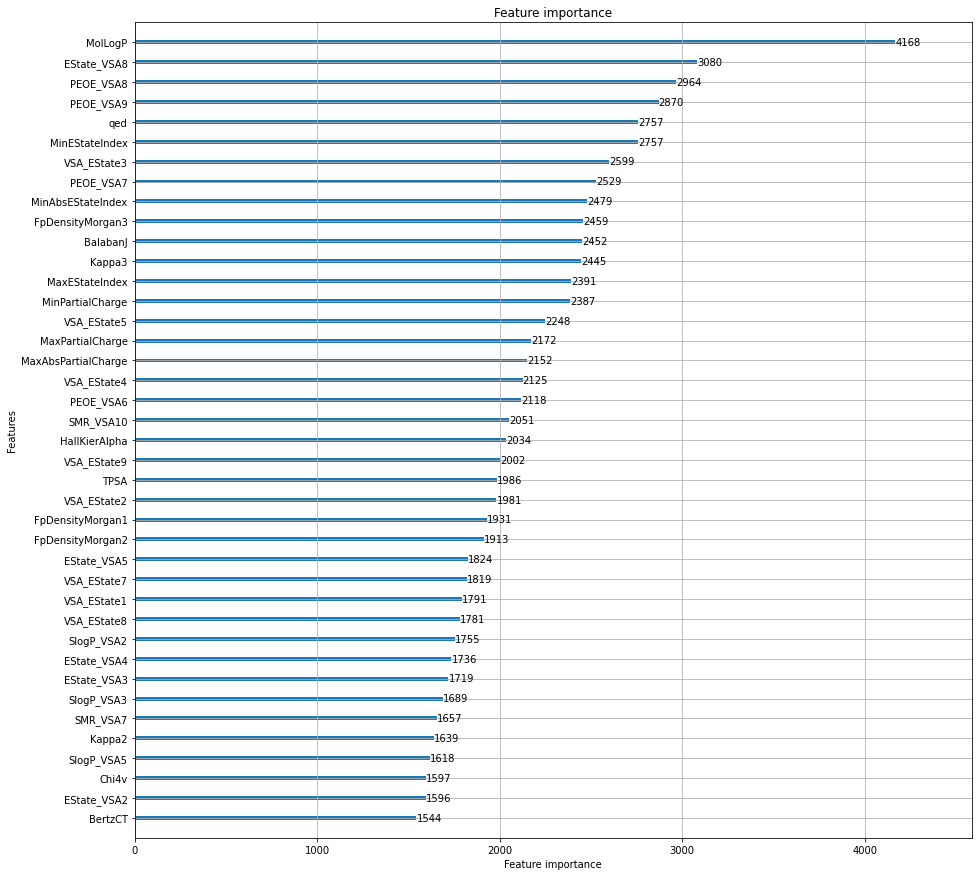

In [21]:
lgb.plot_importance(model, max_num_features=40, figsize=(15,15))

Not as a suprise, the predicted logP by the internal RDKit module is by far the most important feature. At least this shows, that the setup so far is correct and in fact the ML model learns basically some corrections to this internal logP model.

Lets remove unimportant features, the threshold is somewhat arbitrary, but could of course be optimized further. 

In [22]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns),reverse=True), columns=['Value','Feature'])
feature_imp = feature_imp.loc[feature_imp.Value>10]
feature_imp.shape

(146, 2)

In [23]:
Xtrain = Xtrain[feature_imp.Feature]
Xval = Xval[feature_imp.Feature]

Note this kind of selection is not perfectly clean, as it would have been more correct to carry out the feature selection without peaking at the experimental training data. There are also some more elaborated (and more time-consuming) methods for feature selection, such as [recursive feature elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html). 

Now we do a cross-validation with the selected features. For the cross-validation the RSME ([root mean squared error](https://en.wikipedia.org/wiki/Root-mean-square_deviation)) should be about 0.52 with the RDKit standard descriptors. We also get the standard deviation in order to see how each fold varies from the mean.

In [24]:
results = cross_val_score(model, Xtrain, ytrain, cv=cv, scoring='neg_mean_squared_error', )
print("\nResults: %.2f (%.2f) RMSE" % ((-1 * results.mean())**0.5, (results.std())**0.5))


Results: 0.52 (0.16) RMSE


## Parameter selection

OK - now lets improve the results a bit by optimisation of the LGBM parameters. We vary the learning rate, the sub sampling, i.e. how much of the data samples is left aside for each tree (*stochastic* gradient boosting), and the maximal depth of the regression trees. The number of estimators we set high enough in order to give the classifier the opportunity to do early stopping by monitoring the validation set.

We use basically a gridsearch on the parameter space and here also scikit learn offers the tools for doing this, via the `GridSearchCV` class. Of course we do this using cross-validation in order not to overfit.

Note the `refit` keyword we use, it allows us to return the best estimator after the grid search.  

This step may also take a while, depending on how many parameters we change. Keep in mind that each additional parameter doubles the number of runs for the grid search. Therefore, instead of a grid search sometimes more sophisticated [global search algorithms](https://papers.nips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf) are used for *hyperparameter* tuning.

In [25]:
%%time
parameters = {'n_estimators': [5000], 'learning_rate': [0.01,0.02,0.03],'subsample':[0.5,0.75], 'max_depth': [12,15]}
model = GridSearchCV(model, parameters, scoring='neg_mean_squared_error',cv=cv, n_jobs = 4,refit=True, verbose=0)
model.fit(Xtrain, ytrain, early_stopping_rounds=100,eval_metric=['l1','l2'], eval_set=[(Xtrain, ytrain), (Xval, yval)])
df_res = pd.DataFrame(model.cv_results_)
df_res['rmse'] = (-1*df_res['mean_test_score'])**0.5
print(df_res[['rmse','params','rank_test_score']].sort_values('rank_test_score',ascending=True))

[1]	training's l1: 1.38406	training's l2: 3.22579	valid_1's l1: 1.38373	valid_1's l2: 3.3069
Training until validation scores don't improve for 100 rounds
[2]	training's l1: 1.36138	training's l2: 3.1242	valid_1's l1: 1.362	valid_1's l2: 3.20533
[3]	training's l1: 1.33941	training's l2: 3.02759	valid_1's l1: 1.34078	valid_1's l2: 3.10904
[4]	training's l1: 1.31784	training's l2: 2.93422	valid_1's l1: 1.31987	valid_1's l2: 3.01513
[5]	training's l1: 1.2967	training's l2: 2.84394	valid_1's l1: 1.29928	valid_1's l2: 2.92414
[6]	training's l1: 1.27611	training's l2: 2.7573	valid_1's l1: 1.27916	valid_1's l2: 2.8357
[7]	training's l1: 1.25604	training's l2: 2.67471	valid_1's l1: 1.25986	valid_1's l2: 2.75343
[8]	training's l1: 1.23642	training's l2: 2.59432	valid_1's l1: 1.24088	valid_1's l2: 2.67274
[9]	training's l1: 1.21728	training's l2: 2.51752	valid_1's l1: 1.22237	valid_1's l2: 2.59571
[10]	training's l1: 1.19849	training's l2: 2.44343	valid_1's l1: 1.20435	valid_1's l2: 2.52212
[11]

[94]	training's l1: 0.522231	training's l2: 0.538928	valid_1's l1: 0.565488	valid_1's l2: 0.621238
[95]	training's l1: 0.519476	training's l2: 0.534252	valid_1's l1: 0.562949	valid_1's l2: 0.616528
[96]	training's l1: 0.516784	training's l2: 0.52949	valid_1's l1: 0.560577	valid_1's l2: 0.612065
[97]	training's l1: 0.514217	training's l2: 0.524829	valid_1's l1: 0.558361	valid_1's l2: 0.607648
[98]	training's l1: 0.511916	training's l2: 0.520879	valid_1's l1: 0.556438	valid_1's l2: 0.604058
[99]	training's l1: 0.509446	training's l2: 0.51654	valid_1's l1: 0.554383	valid_1's l2: 0.600125
[100]	training's l1: 0.50682	training's l2: 0.512001	valid_1's l1: 0.552035	valid_1's l2: 0.595653
[101]	training's l1: 0.504576	training's l2: 0.508074	valid_1's l1: 0.549997	valid_1's l2: 0.591962
[102]	training's l1: 0.502218	training's l2: 0.504139	valid_1's l1: 0.547899	valid_1's l2: 0.588055
[103]	training's l1: 0.499678	training's l2: 0.499922	valid_1's l1: 0.545735	valid_1's l2: 0.584059
[104]	tra

[181]	training's l1: 0.390692	training's l2: 0.324558	valid_1's l1: 0.4571	valid_1's l2: 0.424052
[182]	training's l1: 0.390012	training's l2: 0.323382	valid_1's l1: 0.456554	valid_1's l2: 0.423103
[183]	training's l1: 0.389119	training's l2: 0.322121	valid_1's l1: 0.455954	valid_1's l2: 0.422145
[184]	training's l1: 0.38802	training's l2: 0.320415	valid_1's l1: 0.455046	valid_1's l2: 0.420452
[185]	training's l1: 0.387211	training's l2: 0.319143	valid_1's l1: 0.454471	valid_1's l2: 0.419458
[186]	training's l1: 0.386439	training's l2: 0.317894	valid_1's l1: 0.453807	valid_1's l2: 0.418265
[187]	training's l1: 0.385675	training's l2: 0.316732	valid_1's l1: 0.453221	valid_1's l2: 0.417207
[188]	training's l1: 0.385033	training's l2: 0.315648	valid_1's l1: 0.452799	valid_1's l2: 0.416397
[189]	training's l1: 0.38428	training's l2: 0.314441	valid_1's l1: 0.452347	valid_1's l2: 0.415594
[190]	training's l1: 0.383339	training's l2: 0.312871	valid_1's l1: 0.451548	valid_1's l2: 0.41429
[191]

[276]	training's l1: 0.336926	training's l2: 0.241908	valid_1's l1: 0.418216	valid_1's l2: 0.35525
[277]	training's l1: 0.336515	training's l2: 0.241212	valid_1's l1: 0.417881	valid_1's l2: 0.354723
[278]	training's l1: 0.336237	training's l2: 0.24077	valid_1's l1: 0.417654	valid_1's l2: 0.354362
[279]	training's l1: 0.335943	training's l2: 0.240366	valid_1's l1: 0.417428	valid_1's l2: 0.353991
[280]	training's l1: 0.335503	training's l2: 0.23981	valid_1's l1: 0.417063	valid_1's l2: 0.353412
[281]	training's l1: 0.335126	training's l2: 0.23918	valid_1's l1: 0.416814	valid_1's l2: 0.352876
[282]	training's l1: 0.334773	training's l2: 0.238589	valid_1's l1: 0.416571	valid_1's l2: 0.352465
[283]	training's l1: 0.334356	training's l2: 0.238027	valid_1's l1: 0.416261	valid_1's l2: 0.352027
[284]	training's l1: 0.333991	training's l2: 0.237415	valid_1's l1: 0.415996	valid_1's l2: 0.351576
[285]	training's l1: 0.333604	training's l2: 0.236873	valid_1's l1: 0.4157	valid_1's l2: 0.351195
[286]	

[359]	training's l1: 0.308932	training's l2: 0.202231	valid_1's l1: 0.398642	valid_1's l2: 0.324766
[360]	training's l1: 0.308676	training's l2: 0.201829	valid_1's l1: 0.398441	valid_1's l2: 0.324462
[361]	training's l1: 0.30831	training's l2: 0.201304	valid_1's l1: 0.398221	valid_1's l2: 0.324181
[362]	training's l1: 0.30808	training's l2: 0.200938	valid_1's l1: 0.39808	valid_1's l2: 0.323995
[363]	training's l1: 0.307865	training's l2: 0.200585	valid_1's l1: 0.397969	valid_1's l2: 0.323828
[364]	training's l1: 0.307603	training's l2: 0.200204	valid_1's l1: 0.397788	valid_1's l2: 0.323542
[365]	training's l1: 0.307283	training's l2: 0.19977	valid_1's l1: 0.397608	valid_1's l2: 0.323273
[366]	training's l1: 0.30708	training's l2: 0.199494	valid_1's l1: 0.397477	valid_1's l2: 0.323072
[367]	training's l1: 0.306782	training's l2: 0.199109	valid_1's l1: 0.397274	valid_1's l2: 0.322792
[368]	training's l1: 0.306587	training's l2: 0.198851	valid_1's l1: 0.397123	valid_1's l2: 0.322502
[369]

[456]	training's l1: 0.283383	training's l2: 0.169338	valid_1's l1: 0.38337	valid_1's l2: 0.301821
[457]	training's l1: 0.283147	training's l2: 0.169058	valid_1's l1: 0.383236	valid_1's l2: 0.301595
[458]	training's l1: 0.282973	training's l2: 0.168855	valid_1's l1: 0.383072	valid_1's l2: 0.301439
[459]	training's l1: 0.282706	training's l2: 0.168515	valid_1's l1: 0.383003	valid_1's l2: 0.301266
[460]	training's l1: 0.282399	training's l2: 0.168171	valid_1's l1: 0.382864	valid_1's l2: 0.301084
[461]	training's l1: 0.282197	training's l2: 0.167915	valid_1's l1: 0.382765	valid_1's l2: 0.300899
[462]	training's l1: 0.281916	training's l2: 0.167588	valid_1's l1: 0.382665	valid_1's l2: 0.300793
[463]	training's l1: 0.281726	training's l2: 0.167356	valid_1's l1: 0.382495	valid_1's l2: 0.300532
[464]	training's l1: 0.281572	training's l2: 0.16716	valid_1's l1: 0.382428	valid_1's l2: 0.300434
[465]	training's l1: 0.281306	training's l2: 0.166789	valid_1's l1: 0.382165	valid_1's l2: 0.300105
[4

[542]	training's l1: 0.263992	training's l2: 0.14665	valid_1's l1: 0.373753	valid_1's l2: 0.287469
[543]	training's l1: 0.263806	training's l2: 0.146446	valid_1's l1: 0.37367	valid_1's l2: 0.287355
[544]	training's l1: 0.26373	training's l2: 0.146349	valid_1's l1: 0.373613	valid_1's l2: 0.287281
[545]	training's l1: 0.263517	training's l2: 0.146131	valid_1's l1: 0.373535	valid_1's l2: 0.287178
[546]	training's l1: 0.26337	training's l2: 0.145934	valid_1's l1: 0.373471	valid_1's l2: 0.287066
[547]	training's l1: 0.26328	training's l2: 0.145817	valid_1's l1: 0.37348	valid_1's l2: 0.287047
[548]	training's l1: 0.262959	training's l2: 0.145488	valid_1's l1: 0.373408	valid_1's l2: 0.286873
[549]	training's l1: 0.262888	training's l2: 0.145383	valid_1's l1: 0.373379	valid_1's l2: 0.286787
[550]	training's l1: 0.262787	training's l2: 0.145255	valid_1's l1: 0.373313	valid_1's l2: 0.286691
[551]	training's l1: 0.262432	training's l2: 0.144888	valid_1's l1: 0.373159	valid_1's l2: 0.286508
[552]	

[625]	training's l1: 0.248723	training's l2: 0.130118	valid_1's l1: 0.366634	valid_1's l2: 0.277194
[626]	training's l1: 0.248427	training's l2: 0.129817	valid_1's l1: 0.36658	valid_1's l2: 0.277062
[627]	training's l1: 0.24836	training's l2: 0.129711	valid_1's l1: 0.366548	valid_1's l2: 0.277002
[628]	training's l1: 0.248111	training's l2: 0.129453	valid_1's l1: 0.366418	valid_1's l2: 0.276855
[629]	training's l1: 0.24794	training's l2: 0.129251	valid_1's l1: 0.366355	valid_1's l2: 0.276758
[630]	training's l1: 0.247757	training's l2: 0.129082	valid_1's l1: 0.366241	valid_1's l2: 0.276634
[631]	training's l1: 0.247478	training's l2: 0.128808	valid_1's l1: 0.366148	valid_1's l2: 0.276516
[632]	training's l1: 0.247356	training's l2: 0.12869	valid_1's l1: 0.366086	valid_1's l2: 0.276418
[633]	training's l1: 0.247233	training's l2: 0.12855	valid_1's l1: 0.366089	valid_1's l2: 0.276421
[634]	training's l1: 0.247072	training's l2: 0.128385	valid_1's l1: 0.365993	valid_1's l2: 0.276274
[635]

[709]	training's l1: 0.235192	training's l2: 0.11625	valid_1's l1: 0.360864	valid_1's l2: 0.269385
[710]	training's l1: 0.234993	training's l2: 0.116047	valid_1's l1: 0.360826	valid_1's l2: 0.26929
[711]	training's l1: 0.234886	training's l2: 0.115932	valid_1's l1: 0.360794	valid_1's l2: 0.269222
[712]	training's l1: 0.234743	training's l2: 0.115785	valid_1's l1: 0.360691	valid_1's l2: 0.269094
[713]	training's l1: 0.234606	training's l2: 0.115654	valid_1's l1: 0.360608	valid_1's l2: 0.268976
[714]	training's l1: 0.234511	training's l2: 0.115543	valid_1's l1: 0.36058	valid_1's l2: 0.268894
[715]	training's l1: 0.234459	training's l2: 0.115478	valid_1's l1: 0.360521	valid_1's l2: 0.268836
[716]	training's l1: 0.23422	training's l2: 0.115266	valid_1's l1: 0.360422	valid_1's l2: 0.268757
[717]	training's l1: 0.234051	training's l2: 0.115115	valid_1's l1: 0.360309	valid_1's l2: 0.268649
[718]	training's l1: 0.233949	training's l2: 0.115009	valid_1's l1: 0.360265	valid_1's l2: 0.268609
[719

[796]	training's l1: 0.223579	training's l2: 0.104957	valid_1's l1: 0.356137	valid_1's l2: 0.26267
[797]	training's l1: 0.223489	training's l2: 0.104869	valid_1's l1: 0.356118	valid_1's l2: 0.262613
[798]	training's l1: 0.223393	training's l2: 0.10477	valid_1's l1: 0.356114	valid_1's l2: 0.26259
[799]	training's l1: 0.22329	training's l2: 0.104671	valid_1's l1: 0.356103	valid_1's l2: 0.262566
[800]	training's l1: 0.223171	training's l2: 0.104558	valid_1's l1: 0.355997	valid_1's l2: 0.262469
[801]	training's l1: 0.22305	training's l2: 0.104433	valid_1's l1: 0.355928	valid_1's l2: 0.262391
[802]	training's l1: 0.222939	training's l2: 0.104332	valid_1's l1: 0.355901	valid_1's l2: 0.262364
[803]	training's l1: 0.222844	training's l2: 0.104256	valid_1's l1: 0.355895	valid_1's l2: 0.262331
[804]	training's l1: 0.222753	training's l2: 0.104174	valid_1's l1: 0.355889	valid_1's l2: 0.262312
[805]	training's l1: 0.222585	training's l2: 0.104017	valid_1's l1: 0.355808	valid_1's l2: 0.262196
[806]

[895]	training's l1: 0.211672	training's l2: 0.0939014	valid_1's l1: 0.352128	valid_1's l2: 0.257167
[896]	training's l1: 0.211615	training's l2: 0.0938418	valid_1's l1: 0.352088	valid_1's l2: 0.257097
[897]	training's l1: 0.211459	training's l2: 0.0937038	valid_1's l1: 0.352059	valid_1's l2: 0.257051
[898]	training's l1: 0.211326	training's l2: 0.0935783	valid_1's l1: 0.352056	valid_1's l2: 0.257089
[899]	training's l1: 0.211236	training's l2: 0.0934744	valid_1's l1: 0.352033	valid_1's l2: 0.257017
[900]	training's l1: 0.211037	training's l2: 0.093309	valid_1's l1: 0.351907	valid_1's l2: 0.256885
[901]	training's l1: 0.210983	training's l2: 0.093249	valid_1's l1: 0.351898	valid_1's l2: 0.256866
[902]	training's l1: 0.210829	training's l2: 0.0931177	valid_1's l1: 0.351909	valid_1's l2: 0.256858
[903]	training's l1: 0.210788	training's l2: 0.0930617	valid_1's l1: 0.351887	valid_1's l2: 0.256824
[904]	training's l1: 0.210637	training's l2: 0.0929383	valid_1's l1: 0.351845	valid_1's l2: 0

[988]	training's l1: 0.200766	training's l2: 0.0842946	valid_1's l1: 0.348855	valid_1's l2: 0.252635
[989]	training's l1: 0.200695	training's l2: 0.0842239	valid_1's l1: 0.348841	valid_1's l2: 0.252611
[990]	training's l1: 0.200564	training's l2: 0.0841187	valid_1's l1: 0.348747	valid_1's l2: 0.252491
[991]	training's l1: 0.200367	training's l2: 0.0839634	valid_1's l1: 0.348724	valid_1's l2: 0.252439
[992]	training's l1: 0.200198	training's l2: 0.083828	valid_1's l1: 0.348639	valid_1's l2: 0.252354
[993]	training's l1: 0.200118	training's l2: 0.0837483	valid_1's l1: 0.348633	valid_1's l2: 0.252332
[994]	training's l1: 0.20005	training's l2: 0.0836918	valid_1's l1: 0.348611	valid_1's l2: 0.252285
[995]	training's l1: 0.199977	training's l2: 0.0836314	valid_1's l1: 0.348638	valid_1's l2: 0.252295
[996]	training's l1: 0.199859	training's l2: 0.0835434	valid_1's l1: 0.348635	valid_1's l2: 0.252286
[997]	training's l1: 0.199697	training's l2: 0.0834162	valid_1's l1: 0.34863	valid_1's l2: 0.

[1081]	training's l1: 0.191188	training's l2: 0.0763815	valid_1's l1: 0.345886	valid_1's l2: 0.248664
[1082]	training's l1: 0.191107	training's l2: 0.0763244	valid_1's l1: 0.345851	valid_1's l2: 0.248638
[1083]	training's l1: 0.191047	training's l2: 0.0762689	valid_1's l1: 0.345818	valid_1's l2: 0.24861
[1084]	training's l1: 0.190974	training's l2: 0.0762193	valid_1's l1: 0.34579	valid_1's l2: 0.248572
[1085]	training's l1: 0.190855	training's l2: 0.0761257	valid_1's l1: 0.345747	valid_1's l2: 0.248516
[1086]	training's l1: 0.190776	training's l2: 0.0760552	valid_1's l1: 0.345716	valid_1's l2: 0.248483
[1087]	training's l1: 0.190653	training's l2: 0.0759428	valid_1's l1: 0.345699	valid_1's l2: 0.248401
[1088]	training's l1: 0.19056	training's l2: 0.0758754	valid_1's l1: 0.34566	valid_1's l2: 0.248344
[1089]	training's l1: 0.19041	training's l2: 0.0757619	valid_1's l1: 0.345628	valid_1's l2: 0.248299
[1090]	training's l1: 0.190372	training's l2: 0.0757191	valid_1's l1: 0.345602	valid_1'

[1176]	training's l1: 0.1823	training's l2: 0.0693679	valid_1's l1: 0.343274	valid_1's l2: 0.245353
[1177]	training's l1: 0.182253	training's l2: 0.0693316	valid_1's l1: 0.343248	valid_1's l2: 0.245322
[1178]	training's l1: 0.182158	training's l2: 0.0692554	valid_1's l1: 0.343225	valid_1's l2: 0.245315
[1179]	training's l1: 0.182095	training's l2: 0.0692	valid_1's l1: 0.343219	valid_1's l2: 0.245297
[1180]	training's l1: 0.182047	training's l2: 0.0691645	valid_1's l1: 0.343196	valid_1's l2: 0.24529
[1181]	training's l1: 0.181951	training's l2: 0.069097	valid_1's l1: 0.343179	valid_1's l2: 0.24531
[1182]	training's l1: 0.181802	training's l2: 0.0689939	valid_1's l1: 0.343157	valid_1's l2: 0.245276
[1183]	training's l1: 0.181769	training's l2: 0.068965	valid_1's l1: 0.343133	valid_1's l2: 0.245251
[1184]	training's l1: 0.181675	training's l2: 0.0688851	valid_1's l1: 0.343128	valid_1's l2: 0.245227
[1185]	training's l1: 0.181579	training's l2: 0.0688227	valid_1's l1: 0.343099	valid_1's l2

[1259]	training's l1: 0.17536	training's l2: 0.0640664	valid_1's l1: 0.341136	valid_1's l2: 0.242962
[1260]	training's l1: 0.175204	training's l2: 0.0639598	valid_1's l1: 0.341096	valid_1's l2: 0.242878
[1261]	training's l1: 0.175103	training's l2: 0.0638807	valid_1's l1: 0.341094	valid_1's l2: 0.242877
[1262]	training's l1: 0.175022	training's l2: 0.063814	valid_1's l1: 0.341099	valid_1's l2: 0.242864
[1263]	training's l1: 0.174915	training's l2: 0.063732	valid_1's l1: 0.34111	valid_1's l2: 0.242872
[1264]	training's l1: 0.174873	training's l2: 0.0636938	valid_1's l1: 0.341104	valid_1's l2: 0.242862
[1265]	training's l1: 0.174755	training's l2: 0.0636136	valid_1's l1: 0.341064	valid_1's l2: 0.242847
[1266]	training's l1: 0.174679	training's l2: 0.0635603	valid_1's l1: 0.341036	valid_1's l2: 0.242831
[1267]	training's l1: 0.17457	training's l2: 0.0634814	valid_1's l1: 0.341036	valid_1's l2: 0.242836
[1268]	training's l1: 0.174479	training's l2: 0.0634222	valid_1's l1: 0.341017	valid_1'

[1359]	training's l1: 0.167534	training's l2: 0.0583361	valid_1's l1: 0.339141	valid_1's l2: 0.240588
[1360]	training's l1: 0.167464	training's l2: 0.0582855	valid_1's l1: 0.339114	valid_1's l2: 0.240581
[1361]	training's l1: 0.167425	training's l2: 0.058255	valid_1's l1: 0.339127	valid_1's l2: 0.24059
[1362]	training's l1: 0.16734	training's l2: 0.0581989	valid_1's l1: 0.339112	valid_1's l2: 0.240595
[1363]	training's l1: 0.167267	training's l2: 0.0581492	valid_1's l1: 0.339125	valid_1's l2: 0.240574
[1364]	training's l1: 0.167213	training's l2: 0.0581091	valid_1's l1: 0.339097	valid_1's l2: 0.240545
[1365]	training's l1: 0.167171	training's l2: 0.0580818	valid_1's l1: 0.339088	valid_1's l2: 0.240539
[1366]	training's l1: 0.167146	training's l2: 0.0580624	valid_1's l1: 0.339064	valid_1's l2: 0.240521
[1367]	training's l1: 0.167097	training's l2: 0.058022	valid_1's l1: 0.339014	valid_1's l2: 0.240483
[1368]	training's l1: 0.167033	training's l2: 0.0579772	valid_1's l1: 0.338996	valid_1

[1444]	training's l1: 0.161089	training's l2: 0.0539065	valid_1's l1: 0.33737	valid_1's l2: 0.238535
[1445]	training's l1: 0.161063	training's l2: 0.0538864	valid_1's l1: 0.337356	valid_1's l2: 0.238509
[1446]	training's l1: 0.161032	training's l2: 0.0538534	valid_1's l1: 0.337338	valid_1's l2: 0.23849
[1447]	training's l1: 0.160921	training's l2: 0.0537696	valid_1's l1: 0.337411	valid_1's l2: 0.238536
[1448]	training's l1: 0.160883	training's l2: 0.0537421	valid_1's l1: 0.337401	valid_1's l2: 0.23854
[1449]	training's l1: 0.160818	training's l2: 0.0536925	valid_1's l1: 0.337359	valid_1's l2: 0.238472
[1450]	training's l1: 0.160711	training's l2: 0.053626	valid_1's l1: 0.337271	valid_1's l2: 0.2384
[1451]	training's l1: 0.16068	training's l2: 0.0536007	valid_1's l1: 0.337257	valid_1's l2: 0.238388
[1452]	training's l1: 0.160615	training's l2: 0.0535567	valid_1's l1: 0.337227	valid_1's l2: 0.238353
[1453]	training's l1: 0.16054	training's l2: 0.0535021	valid_1's l1: 0.337184	valid_1's l

[1527]	training's l1: 0.155509	training's l2: 0.0501835	valid_1's l1: 0.335927	valid_1's l2: 0.23685
[1528]	training's l1: 0.155416	training's l2: 0.0501228	valid_1's l1: 0.335894	valid_1's l2: 0.23682
[1529]	training's l1: 0.155343	training's l2: 0.0500766	valid_1's l1: 0.335854	valid_1's l2: 0.236788
[1530]	training's l1: 0.155212	training's l2: 0.0499958	valid_1's l1: 0.335887	valid_1's l2: 0.236786
[1531]	training's l1: 0.155125	training's l2: 0.0499371	valid_1's l1: 0.335877	valid_1's l2: 0.236776
[1532]	training's l1: 0.15507	training's l2: 0.0498986	valid_1's l1: 0.335876	valid_1's l2: 0.236776
[1533]	training's l1: 0.155018	training's l2: 0.0498594	valid_1's l1: 0.335876	valid_1's l2: 0.236765
[1534]	training's l1: 0.154914	training's l2: 0.0498	valid_1's l1: 0.335828	valid_1's l2: 0.236707
[1535]	training's l1: 0.154865	training's l2: 0.0497613	valid_1's l1: 0.335841	valid_1's l2: 0.236736
[1536]	training's l1: 0.154781	training's l2: 0.0497125	valid_1's l1: 0.335832	valid_1's

[1619]	training's l1: 0.149177	training's l2: 0.0461592	valid_1's l1: 0.334623	valid_1's l2: 0.235217
[1620]	training's l1: 0.149071	training's l2: 0.0461038	valid_1's l1: 0.334634	valid_1's l2: 0.235232
[1621]	training's l1: 0.149021	training's l2: 0.0460675	valid_1's l1: 0.334631	valid_1's l2: 0.235233
[1622]	training's l1: 0.148923	training's l2: 0.0460088	valid_1's l1: 0.334558	valid_1's l2: 0.235164
[1623]	training's l1: 0.148821	training's l2: 0.0459489	valid_1's l1: 0.334538	valid_1's l2: 0.235144
[1624]	training's l1: 0.148698	training's l2: 0.0458825	valid_1's l1: 0.334558	valid_1's l2: 0.235161
[1625]	training's l1: 0.148645	training's l2: 0.0458436	valid_1's l1: 0.334558	valid_1's l2: 0.235149
[1626]	training's l1: 0.14862	training's l2: 0.0458306	valid_1's l1: 0.334536	valid_1's l2: 0.235139
[1627]	training's l1: 0.148542	training's l2: 0.0457787	valid_1's l1: 0.334505	valid_1's l2: 0.235138
[1628]	training's l1: 0.148447	training's l2: 0.0457266	valid_1's l1: 0.334486	vali

[1714]	training's l1: 0.143295	training's l2: 0.0426619	valid_1's l1: 0.333393	valid_1's l2: 0.23401
[1715]	training's l1: 0.143264	training's l2: 0.0426437	valid_1's l1: 0.333395	valid_1's l2: 0.234007
[1716]	training's l1: 0.143162	training's l2: 0.0425885	valid_1's l1: 0.33335	valid_1's l2: 0.233965
[1717]	training's l1: 0.143103	training's l2: 0.0425542	valid_1's l1: 0.333342	valid_1's l2: 0.233961
[1718]	training's l1: 0.143022	training's l2: 0.0425119	valid_1's l1: 0.333312	valid_1's l2: 0.233926
[1719]	training's l1: 0.142986	training's l2: 0.0424868	valid_1's l1: 0.333301	valid_1's l2: 0.233926
[1720]	training's l1: 0.142935	training's l2: 0.0424496	valid_1's l1: 0.333317	valid_1's l2: 0.23391
[1721]	training's l1: 0.142896	training's l2: 0.0424202	valid_1's l1: 0.333302	valid_1's l2: 0.23389
[1722]	training's l1: 0.142793	training's l2: 0.0423599	valid_1's l1: 0.333339	valid_1's l2: 0.233914
[1723]	training's l1: 0.142778	training's l2: 0.042347	valid_1's l1: 0.33333	valid_1's

[1807]	training's l1: 0.138053	training's l2: 0.0396424	valid_1's l1: 0.332397	valid_1's l2: 0.232753
[1808]	training's l1: 0.138037	training's l2: 0.0396296	valid_1's l1: 0.332411	valid_1's l2: 0.23276
[1809]	training's l1: 0.138004	training's l2: 0.0396116	valid_1's l1: 0.332407	valid_1's l2: 0.232743
[1810]	training's l1: 0.1379	training's l2: 0.0395633	valid_1's l1: 0.332398	valid_1's l2: 0.232732
[1811]	training's l1: 0.137853	training's l2: 0.0395273	valid_1's l1: 0.332369	valid_1's l2: 0.23268
[1812]	training's l1: 0.137838	training's l2: 0.0395169	valid_1's l1: 0.332356	valid_1's l2: 0.232675
[1813]	training's l1: 0.137796	training's l2: 0.0394973	valid_1's l1: 0.332368	valid_1's l2: 0.232671
[1814]	training's l1: 0.13771	training's l2: 0.0394522	valid_1's l1: 0.332346	valid_1's l2: 0.232649
[1815]	training's l1: 0.137614	training's l2: 0.0394051	valid_1's l1: 0.332314	valid_1's l2: 0.232636
[1816]	training's l1: 0.137585	training's l2: 0.0393808	valid_1's l1: 0.332317	valid_1'

[1903]	training's l1: 0.133021	training's l2: 0.0368376	valid_1's l1: 0.331349	valid_1's l2: 0.231504
[1904]	training's l1: 0.132973	training's l2: 0.0368096	valid_1's l1: 0.331343	valid_1's l2: 0.23149
[1905]	training's l1: 0.1329	training's l2: 0.0367724	valid_1's l1: 0.331332	valid_1's l2: 0.231483
[1906]	training's l1: 0.132871	training's l2: 0.0367526	valid_1's l1: 0.331336	valid_1's l2: 0.231482
[1907]	training's l1: 0.132822	training's l2: 0.0367276	valid_1's l1: 0.331319	valid_1's l2: 0.231459
[1908]	training's l1: 0.132787	training's l2: 0.0367078	valid_1's l1: 0.331317	valid_1's l2: 0.231457
[1909]	training's l1: 0.13274	training's l2: 0.0366839	valid_1's l1: 0.331307	valid_1's l2: 0.231447
[1910]	training's l1: 0.132708	training's l2: 0.036666	valid_1's l1: 0.331269	valid_1's l2: 0.231411
[1911]	training's l1: 0.132666	training's l2: 0.0366416	valid_1's l1: 0.331237	valid_1's l2: 0.231384
[1912]	training's l1: 0.13257	training's l2: 0.0365988	valid_1's l1: 0.331232	valid_1's

[1984]	training's l1: 0.128715	training's l2: 0.0344992	valid_1's l1: 0.33065	valid_1's l2: 0.230631
[1985]	training's l1: 0.128624	training's l2: 0.0344571	valid_1's l1: 0.330627	valid_1's l2: 0.230614
[1986]	training's l1: 0.128546	training's l2: 0.0344108	valid_1's l1: 0.330612	valid_1's l2: 0.230628
[1987]	training's l1: 0.128527	training's l2: 0.0344027	valid_1's l1: 0.330609	valid_1's l2: 0.230616
[1988]	training's l1: 0.128494	training's l2: 0.034385	valid_1's l1: 0.330608	valid_1's l2: 0.230638
[1989]	training's l1: 0.128473	training's l2: 0.0343742	valid_1's l1: 0.330602	valid_1's l2: 0.230633
[1990]	training's l1: 0.128428	training's l2: 0.0343521	valid_1's l1: 0.33059	valid_1's l2: 0.230608
[1991]	training's l1: 0.128383	training's l2: 0.0343261	valid_1's l1: 0.330606	valid_1's l2: 0.230606
[1992]	training's l1: 0.128322	training's l2: 0.0342983	valid_1's l1: 0.330591	valid_1's l2: 0.230597
[1993]	training's l1: 0.128292	training's l2: 0.0342837	valid_1's l1: 0.330578	valid_

[2081]	training's l1: 0.123671	training's l2: 0.0319668	valid_1's l1: 0.32974	valid_1's l2: 0.229545
[2082]	training's l1: 0.123661	training's l2: 0.031957	valid_1's l1: 0.329745	valid_1's l2: 0.229532
[2083]	training's l1: 0.123612	training's l2: 0.0319299	valid_1's l1: 0.329715	valid_1's l2: 0.229518
[2084]	training's l1: 0.123551	training's l2: 0.0319025	valid_1's l1: 0.329706	valid_1's l2: 0.229512
[2085]	training's l1: 0.123513	training's l2: 0.0318815	valid_1's l1: 0.329746	valid_1's l2: 0.229525
[2086]	training's l1: 0.123442	training's l2: 0.0318457	valid_1's l1: 0.32973	valid_1's l2: 0.229495
[2087]	training's l1: 0.123427	training's l2: 0.0318374	valid_1's l1: 0.329727	valid_1's l2: 0.229494
[2088]	training's l1: 0.123392	training's l2: 0.0318151	valid_1's l1: 0.329718	valid_1's l2: 0.22949
[2089]	training's l1: 0.12333	training's l2: 0.0317872	valid_1's l1: 0.32974	valid_1's l2: 0.229494
[2090]	training's l1: 0.123276	training's l2: 0.0317577	valid_1's l1: 0.329726	valid_1's

[2178]	training's l1: 0.119	training's l2: 0.0296558	valid_1's l1: 0.329117	valid_1's l2: 0.228812
[2179]	training's l1: 0.118911	training's l2: 0.0296165	valid_1's l1: 0.329089	valid_1's l2: 0.228801
[2180]	training's l1: 0.118887	training's l2: 0.0296058	valid_1's l1: 0.329088	valid_1's l2: 0.228808
[2181]	training's l1: 0.118881	training's l2: 0.0296009	valid_1's l1: 0.329094	valid_1's l2: 0.228813
[2182]	training's l1: 0.118843	training's l2: 0.029578	valid_1's l1: 0.329075	valid_1's l2: 0.22882
[2183]	training's l1: 0.118789	training's l2: 0.0295548	valid_1's l1: 0.329054	valid_1's l2: 0.228787
[2184]	training's l1: 0.118744	training's l2: 0.0295339	valid_1's l1: 0.32904	valid_1's l2: 0.22876
[2185]	training's l1: 0.118692	training's l2: 0.0295098	valid_1's l1: 0.329059	valid_1's l2: 0.228763
[2186]	training's l1: 0.118622	training's l2: 0.029476	valid_1's l1: 0.329045	valid_1's l2: 0.228754
[2187]	training's l1: 0.118577	training's l2: 0.0294517	valid_1's l1: 0.329058	valid_1's l

[2264]	training's l1: 0.115204	training's l2: 0.0278772	valid_1's l1: 0.328602	valid_1's l2: 0.22828
[2265]	training's l1: 0.115172	training's l2: 0.0278607	valid_1's l1: 0.328581	valid_1's l2: 0.228275
[2266]	training's l1: 0.115148	training's l2: 0.0278476	valid_1's l1: 0.328574	valid_1's l2: 0.228261
[2267]	training's l1: 0.115084	training's l2: 0.0278185	valid_1's l1: 0.328557	valid_1's l2: 0.228257
[2268]	training's l1: 0.115054	training's l2: 0.0277984	valid_1's l1: 0.328531	valid_1's l2: 0.228238
[2269]	training's l1: 0.115	training's l2: 0.0277757	valid_1's l1: 0.328499	valid_1's l2: 0.2282
[2270]	training's l1: 0.114982	training's l2: 0.0277658	valid_1's l1: 0.328494	valid_1's l2: 0.228196
[2271]	training's l1: 0.11494	training's l2: 0.0277497	valid_1's l1: 0.328487	valid_1's l2: 0.228212
[2272]	training's l1: 0.114874	training's l2: 0.0277184	valid_1's l1: 0.328492	valid_1's l2: 0.228199
[2273]	training's l1: 0.114843	training's l2: 0.0277031	valid_1's l1: 0.328482	valid_1's 

[2352]	training's l1: 0.111317	training's l2: 0.0261079	valid_1's l1: 0.327956	valid_1's l2: 0.227611
[2353]	training's l1: 0.111296	training's l2: 0.0261015	valid_1's l1: 0.327943	valid_1's l2: 0.227606
[2354]	training's l1: 0.111248	training's l2: 0.0260808	valid_1's l1: 0.327951	valid_1's l2: 0.227609
[2355]	training's l1: 0.111225	training's l2: 0.0260707	valid_1's l1: 0.327947	valid_1's l2: 0.227599
[2356]	training's l1: 0.111196	training's l2: 0.026059	valid_1's l1: 0.327939	valid_1's l2: 0.227592
[2357]	training's l1: 0.111186	training's l2: 0.0260524	valid_1's l1: 0.327951	valid_1's l2: 0.227608
[2358]	training's l1: 0.111131	training's l2: 0.026026	valid_1's l1: 0.327951	valid_1's l2: 0.227628
[2359]	training's l1: 0.111075	training's l2: 0.0260035	valid_1's l1: 0.327944	valid_1's l2: 0.227611
[2360]	training's l1: 0.111023	training's l2: 0.0259775	valid_1's l1: 0.327931	valid_1's l2: 0.227622
[2361]	training's l1: 0.110998	training's l2: 0.0259642	valid_1's l1: 0.327914	valid

[2446]	training's l1: 0.107369	training's l2: 0.0243858	valid_1's l1: 0.327442	valid_1's l2: 0.227185
[2447]	training's l1: 0.107306	training's l2: 0.0243628	valid_1's l1: 0.327428	valid_1's l2: 0.227183
[2448]	training's l1: 0.107301	training's l2: 0.0243586	valid_1's l1: 0.327419	valid_1's l2: 0.227177
[2449]	training's l1: 0.107284	training's l2: 0.0243507	valid_1's l1: 0.327412	valid_1's l2: 0.227174
[2450]	training's l1: 0.10725	training's l2: 0.0243331	valid_1's l1: 0.32741	valid_1's l2: 0.227157
[2451]	training's l1: 0.107198	training's l2: 0.0243126	valid_1's l1: 0.327401	valid_1's l2: 0.227157
[2452]	training's l1: 0.107138	training's l2: 0.0242939	valid_1's l1: 0.327404	valid_1's l2: 0.227156
[2453]	training's l1: 0.107124	training's l2: 0.0242847	valid_1's l1: 0.327417	valid_1's l2: 0.227167
[2454]	training's l1: 0.107061	training's l2: 0.0242622	valid_1's l1: 0.327415	valid_1's l2: 0.227181
[2455]	training's l1: 0.107026	training's l2: 0.0242494	valid_1's l1: 0.327412	valid

[2544]	training's l1: 0.103706	training's l2: 0.0228364	valid_1's l1: 0.326953	valid_1's l2: 0.226777
[2545]	training's l1: 0.103663	training's l2: 0.0228204	valid_1's l1: 0.326947	valid_1's l2: 0.226766
[2546]	training's l1: 0.103639	training's l2: 0.02281	valid_1's l1: 0.326954	valid_1's l2: 0.226775
[2547]	training's l1: 0.103592	training's l2: 0.0227893	valid_1's l1: 0.326952	valid_1's l2: 0.226754
[2548]	training's l1: 0.10354	training's l2: 0.022771	valid_1's l1: 0.326948	valid_1's l2: 0.22674
[2549]	training's l1: 0.103518	training's l2: 0.0227629	valid_1's l1: 0.32695	valid_1's l2: 0.226741
[2550]	training's l1: 0.103488	training's l2: 0.0227509	valid_1's l1: 0.326939	valid_1's l2: 0.226711
[2551]	training's l1: 0.103427	training's l2: 0.0227285	valid_1's l1: 0.326926	valid_1's l2: 0.226706
[2552]	training's l1: 0.103393	training's l2: 0.0227172	valid_1's l1: 0.326928	valid_1's l2: 0.226706
[2553]	training's l1: 0.103379	training's l2: 0.0227082	valid_1's l1: 0.326917	valid_1's

[2635]	training's l1: 0.10026	training's l2: 0.0214357	valid_1's l1: 0.326475	valid_1's l2: 0.226324
[2636]	training's l1: 0.10021	training's l2: 0.0214134	valid_1's l1: 0.3265	valid_1's l2: 0.226342
[2637]	training's l1: 0.100184	training's l2: 0.021405	valid_1's l1: 0.326499	valid_1's l2: 0.22633
[2638]	training's l1: 0.100144	training's l2: 0.0213901	valid_1's l1: 0.326481	valid_1's l2: 0.226318
[2639]	training's l1: 0.100106	training's l2: 0.0213763	valid_1's l1: 0.326488	valid_1's l2: 0.226319
[2640]	training's l1: 0.100077	training's l2: 0.0213654	valid_1's l1: 0.326475	valid_1's l2: 0.226318
[2641]	training's l1: 0.100033	training's l2: 0.0213479	valid_1's l1: 0.326472	valid_1's l2: 0.226306
[2642]	training's l1: 0.0999989	training's l2: 0.0213324	valid_1's l1: 0.326481	valid_1's l2: 0.226318
[2643]	training's l1: 0.0999588	training's l2: 0.0213179	valid_1's l1: 0.326471	valid_1's l2: 0.226302
[2644]	training's l1: 0.099924	training's l2: 0.0213047	valid_1's l1: 0.326482	valid_1

[2717]	training's l1: 0.0974045	training's l2: 0.0203223	valid_1's l1: 0.32613	valid_1's l2: 0.225898
[2718]	training's l1: 0.0973867	training's l2: 0.0203129	valid_1's l1: 0.326121	valid_1's l2: 0.225897
[2719]	training's l1: 0.0973391	training's l2: 0.020295	valid_1's l1: 0.326109	valid_1's l2: 0.225875
[2720]	training's l1: 0.0973039	training's l2: 0.0202793	valid_1's l1: 0.326088	valid_1's l2: 0.22585
[2721]	training's l1: 0.0972654	training's l2: 0.0202639	valid_1's l1: 0.326085	valid_1's l2: 0.225863
[2722]	training's l1: 0.0972231	training's l2: 0.0202483	valid_1's l1: 0.32608	valid_1's l2: 0.225856
[2723]	training's l1: 0.0971804	training's l2: 0.020235	valid_1's l1: 0.326064	valid_1's l2: 0.225854
[2724]	training's l1: 0.0971502	training's l2: 0.0202216	valid_1's l1: 0.326058	valid_1's l2: 0.225836
[2725]	training's l1: 0.0970886	training's l2: 0.0201955	valid_1's l1: 0.326051	valid_1's l2: 0.225825
[2726]	training's l1: 0.0970385	training's l2: 0.0201762	valid_1's l1: 0.32605

[2797]	training's l1: 0.0946454	training's l2: 0.0192695	valid_1's l1: 0.325767	valid_1's l2: 0.225541
[2798]	training's l1: 0.0945891	training's l2: 0.0192491	valid_1's l1: 0.325737	valid_1's l2: 0.225511
[2799]	training's l1: 0.0945409	training's l2: 0.0192323	valid_1's l1: 0.325726	valid_1's l2: 0.225507
[2800]	training's l1: 0.0945125	training's l2: 0.0192208	valid_1's l1: 0.325719	valid_1's l2: 0.225487
[2801]	training's l1: 0.0944522	training's l2: 0.0192039	valid_1's l1: 0.32571	valid_1's l2: 0.225458
[2802]	training's l1: 0.0944189	training's l2: 0.0191914	valid_1's l1: 0.325717	valid_1's l2: 0.225459
[2803]	training's l1: 0.0943769	training's l2: 0.0191731	valid_1's l1: 0.325719	valid_1's l2: 0.22546
[2804]	training's l1: 0.0943474	training's l2: 0.0191638	valid_1's l1: 0.325712	valid_1's l2: 0.225447
[2805]	training's l1: 0.0943246	training's l2: 0.0191547	valid_1's l1: 0.325708	valid_1's l2: 0.225442
[2806]	training's l1: 0.0942722	training's l2: 0.0191354	valid_1's l1: 0.32

[2889]	training's l1: 0.0915546	training's l2: 0.0181441	valid_1's l1: 0.325384	valid_1's l2: 0.225167
[2890]	training's l1: 0.0915247	training's l2: 0.0181336	valid_1's l1: 0.325388	valid_1's l2: 0.225171
[2891]	training's l1: 0.0914876	training's l2: 0.0181192	valid_1's l1: 0.325378	valid_1's l2: 0.225162
[2892]	training's l1: 0.0914515	training's l2: 0.0181052	valid_1's l1: 0.325385	valid_1's l2: 0.225165
[2893]	training's l1: 0.091417	training's l2: 0.0180939	valid_1's l1: 0.325395	valid_1's l2: 0.225172
[2894]	training's l1: 0.091404	training's l2: 0.0180865	valid_1's l1: 0.325381	valid_1's l2: 0.225171
[2895]	training's l1: 0.0913936	training's l2: 0.0180819	valid_1's l1: 0.325369	valid_1's l2: 0.225171
[2896]	training's l1: 0.0913547	training's l2: 0.0180659	valid_1's l1: 0.325349	valid_1's l2: 0.225154
[2897]	training's l1: 0.0913338	training's l2: 0.0180559	valid_1's l1: 0.325352	valid_1's l2: 0.225154
[2898]	training's l1: 0.0913057	training's l2: 0.0180449	valid_1's l1: 0.32

[2977]	training's l1: 0.0886953	training's l2: 0.0171024	valid_1's l1: 0.325005	valid_1's l2: 0.224815
[2978]	training's l1: 0.0886484	training's l2: 0.0170871	valid_1's l1: 0.325015	valid_1's l2: 0.224817
[2979]	training's l1: 0.0886224	training's l2: 0.0170804	valid_1's l1: 0.325017	valid_1's l2: 0.224816
[2980]	training's l1: 0.0886036	training's l2: 0.0170734	valid_1's l1: 0.325017	valid_1's l2: 0.224817
[2981]	training's l1: 0.088568	training's l2: 0.0170625	valid_1's l1: 0.32502	valid_1's l2: 0.224817
[2982]	training's l1: 0.0885184	training's l2: 0.0170475	valid_1's l1: 0.32502	valid_1's l2: 0.224826
[2983]	training's l1: 0.0884919	training's l2: 0.0170378	valid_1's l1: 0.325023	valid_1's l2: 0.224833
[2984]	training's l1: 0.0884421	training's l2: 0.0170239	valid_1's l1: 0.325014	valid_1's l2: 0.224827
[2985]	training's l1: 0.0884198	training's l2: 0.0170154	valid_1's l1: 0.325029	valid_1's l2: 0.224833
[2986]	training's l1: 0.0883979	training's l2: 0.0170065	valid_1's l1: 0.325

[3063]	training's l1: 0.0860328	training's l2: 0.0161922	valid_1's l1: 0.324788	valid_1's l2: 0.224578
[3064]	training's l1: 0.0860127	training's l2: 0.0161851	valid_1's l1: 0.324792	valid_1's l2: 0.224575
[3065]	training's l1: 0.0859778	training's l2: 0.0161725	valid_1's l1: 0.324796	valid_1's l2: 0.224588
[3066]	training's l1: 0.0859379	training's l2: 0.0161607	valid_1's l1: 0.324771	valid_1's l2: 0.22457
[3067]	training's l1: 0.0859162	training's l2: 0.0161523	valid_1's l1: 0.324767	valid_1's l2: 0.22457
[3068]	training's l1: 0.0858881	training's l2: 0.0161436	valid_1's l1: 0.32476	valid_1's l2: 0.224574
[3069]	training's l1: 0.085873	training's l2: 0.0161395	valid_1's l1: 0.324743	valid_1's l2: 0.224563
[3070]	training's l1: 0.0858476	training's l2: 0.0161317	valid_1's l1: 0.324744	valid_1's l2: 0.22456
[3071]	training's l1: 0.0858408	training's l2: 0.0161281	valid_1's l1: 0.324743	valid_1's l2: 0.224558
[3072]	training's l1: 0.0858098	training's l2: 0.0161187	valid_1's l1: 0.32473

[3150]	training's l1: 0.0834786	training's l2: 0.0153674	valid_1's l1: 0.324447	valid_1's l2: 0.22428
[3151]	training's l1: 0.0834544	training's l2: 0.0153592	valid_1's l1: 0.324461	valid_1's l2: 0.224289
[3152]	training's l1: 0.0834351	training's l2: 0.0153542	valid_1's l1: 0.324454	valid_1's l2: 0.224276
[3153]	training's l1: 0.0834224	training's l2: 0.0153501	valid_1's l1: 0.324461	valid_1's l2: 0.224276
[3154]	training's l1: 0.0834031	training's l2: 0.0153436	valid_1's l1: 0.324447	valid_1's l2: 0.224266
[3155]	training's l1: 0.0833679	training's l2: 0.0153302	valid_1's l1: 0.324436	valid_1's l2: 0.224249
[3156]	training's l1: 0.0833616	training's l2: 0.0153273	valid_1's l1: 0.324439	valid_1's l2: 0.224253
[3157]	training's l1: 0.0833298	training's l2: 0.0153185	valid_1's l1: 0.324434	valid_1's l2: 0.22424
[3158]	training's l1: 0.0832864	training's l2: 0.0153049	valid_1's l1: 0.324434	valid_1's l2: 0.22424
[3159]	training's l1: 0.0832697	training's l2: 0.0152987	valid_1's l1: 0.324

[3246]	training's l1: 0.0807917	training's l2: 0.0145136	valid_1's l1: 0.324137	valid_1's l2: 0.223915
[3247]	training's l1: 0.0807705	training's l2: 0.0145064	valid_1's l1: 0.32413	valid_1's l2: 0.22392
[3248]	training's l1: 0.0807302	training's l2: 0.0144957	valid_1's l1: 0.324144	valid_1's l2: 0.223922
[3249]	training's l1: 0.0807054	training's l2: 0.0144879	valid_1's l1: 0.324134	valid_1's l2: 0.223913
[3250]	training's l1: 0.0806718	training's l2: 0.0144769	valid_1's l1: 0.324141	valid_1's l2: 0.223913
[3251]	training's l1: 0.0806422	training's l2: 0.0144666	valid_1's l1: 0.324141	valid_1's l2: 0.223917
[3252]	training's l1: 0.0806074	training's l2: 0.0144575	valid_1's l1: 0.324129	valid_1's l2: 0.223898
[3253]	training's l1: 0.0805877	training's l2: 0.0144509	valid_1's l1: 0.324119	valid_1's l2: 0.223885
[3254]	training's l1: 0.0805821	training's l2: 0.0144469	valid_1's l1: 0.324114	valid_1's l2: 0.22388
[3255]	training's l1: 0.0805534	training's l2: 0.0144387	valid_1's l1: 0.324

[3326]	training's l1: 0.0787206	training's l2: 0.0138613	valid_1's l1: 0.323992	valid_1's l2: 0.223808
[3327]	training's l1: 0.0786914	training's l2: 0.0138528	valid_1's l1: 0.323979	valid_1's l2: 0.223811
[3328]	training's l1: 0.0786599	training's l2: 0.0138444	valid_1's l1: 0.323983	valid_1's l2: 0.223801
[3329]	training's l1: 0.0786251	training's l2: 0.0138339	valid_1's l1: 0.323997	valid_1's l2: 0.223817
[3330]	training's l1: 0.0786133	training's l2: 0.0138301	valid_1's l1: 0.323996	valid_1's l2: 0.223815
[3331]	training's l1: 0.0785914	training's l2: 0.0138206	valid_1's l1: 0.324006	valid_1's l2: 0.223839
[3332]	training's l1: 0.0785715	training's l2: 0.0138141	valid_1's l1: 0.324007	valid_1's l2: 0.223834
[3333]	training's l1: 0.0785348	training's l2: 0.0138039	valid_1's l1: 0.324006	valid_1's l2: 0.223845
[3334]	training's l1: 0.0785219	training's l2: 0.0137993	valid_1's l1: 0.324014	valid_1's l2: 0.223854
[3335]	training's l1: 0.0784879	training's l2: 0.0137883	valid_1's l1: 0.

[3498]	training's l1: 0.0744426	training's l2: 0.012578	valid_1's l1: 0.323639	valid_1's l2: 0.223562
[3499]	training's l1: 0.0744009	training's l2: 0.0125648	valid_1's l1: 0.32362	valid_1's l2: 0.223549
[3500]	training's l1: 0.0743876	training's l2: 0.0125616	valid_1's l1: 0.323622	valid_1's l2: 0.223553
[3501]	training's l1: 0.0743503	training's l2: 0.0125505	valid_1's l1: 0.323611	valid_1's l2: 0.223545
[3502]	training's l1: 0.0743228	training's l2: 0.0125399	valid_1's l1: 0.323614	valid_1's l2: 0.223544
[3503]	training's l1: 0.0743019	training's l2: 0.012533	valid_1's l1: 0.32361	valid_1's l2: 0.223525
[3504]	training's l1: 0.0742861	training's l2: 0.012528	valid_1's l1: 0.323612	valid_1's l2: 0.223527
[3505]	training's l1: 0.0742519	training's l2: 0.0125178	valid_1's l1: 0.323602	valid_1's l2: 0.22351
[3506]	training's l1: 0.0742117	training's l2: 0.0125069	valid_1's l1: 0.323588	valid_1's l2: 0.223509
[3507]	training's l1: 0.0741882	training's l2: 0.0125	valid_1's l1: 0.323596	va

[3584]	training's l1: 0.0722988	training's l2: 0.0119613	valid_1's l1: 0.323429	valid_1's l2: 0.223385
[3585]	training's l1: 0.0722821	training's l2: 0.011957	valid_1's l1: 0.323434	valid_1's l2: 0.223395
[3586]	training's l1: 0.0722525	training's l2: 0.0119489	valid_1's l1: 0.323418	valid_1's l2: 0.22339
[3587]	training's l1: 0.0722355	training's l2: 0.0119426	valid_1's l1: 0.323409	valid_1's l2: 0.223381
[3588]	training's l1: 0.0722095	training's l2: 0.0119356	valid_1's l1: 0.323408	valid_1's l2: 0.223377
[3589]	training's l1: 0.0721806	training's l2: 0.0119288	valid_1's l1: 0.323406	valid_1's l2: 0.223372
[3590]	training's l1: 0.0721584	training's l2: 0.0119223	valid_1's l1: 0.323407	valid_1's l2: 0.22338
[3591]	training's l1: 0.0721291	training's l2: 0.0119145	valid_1's l1: 0.323407	valid_1's l2: 0.223381
[3592]	training's l1: 0.072122	training's l2: 0.0119125	valid_1's l1: 0.323409	valid_1's l2: 0.223379
[3593]	training's l1: 0.0721016	training's l2: 0.0119065	valid_1's l1: 0.3234

[3670]	training's l1: 0.0702861	training's l2: 0.0114082	valid_1's l1: 0.323352	valid_1's l2: 0.223291
[3671]	training's l1: 0.0702562	training's l2: 0.0114005	valid_1's l1: 0.32335	valid_1's l2: 0.223297
[3672]	training's l1: 0.0702388	training's l2: 0.0113956	valid_1's l1: 0.323359	valid_1's l2: 0.223307
[3673]	training's l1: 0.0702289	training's l2: 0.0113922	valid_1's l1: 0.323364	valid_1's l2: 0.223305
[3674]	training's l1: 0.0701931	training's l2: 0.0113835	valid_1's l1: 0.323366	valid_1's l2: 0.223301
[3675]	training's l1: 0.0701657	training's l2: 0.0113753	valid_1's l1: 0.32336	valid_1's l2: 0.223306
[3676]	training's l1: 0.070146	training's l2: 0.0113709	valid_1's l1: 0.323352	valid_1's l2: 0.223312
[3677]	training's l1: 0.0701371	training's l2: 0.0113672	valid_1's l1: 0.323358	valid_1's l2: 0.22332
[3678]	training's l1: 0.0701042	training's l2: 0.0113595	valid_1's l1: 0.32336	valid_1's l2: 0.223327
[3679]	training's l1: 0.0700889	training's l2: 0.0113551	valid_1's l1: 0.32335

[3758]	training's l1: 0.0683607	training's l2: 0.0108877	valid_1's l1: 0.323129	valid_1's l2: 0.223175
[3759]	training's l1: 0.0683546	training's l2: 0.0108859	valid_1's l1: 0.323129	valid_1's l2: 0.223181
[3760]	training's l1: 0.0683253	training's l2: 0.0108799	valid_1's l1: 0.323118	valid_1's l2: 0.223168
[3761]	training's l1: 0.0683008	training's l2: 0.0108726	valid_1's l1: 0.323109	valid_1's l2: 0.223151
[3762]	training's l1: 0.0682652	training's l2: 0.0108638	valid_1's l1: 0.323103	valid_1's l2: 0.223142
[3763]	training's l1: 0.0682421	training's l2: 0.0108593	valid_1's l1: 0.323106	valid_1's l2: 0.223151
[3764]	training's l1: 0.0682063	training's l2: 0.010851	valid_1's l1: 0.323118	valid_1's l2: 0.22317
[3765]	training's l1: 0.0681762	training's l2: 0.0108439	valid_1's l1: 0.323124	valid_1's l2: 0.223171
[3766]	training's l1: 0.0681486	training's l2: 0.010837	valid_1's l1: 0.32312	valid_1's l2: 0.223162
[3767]	training's l1: 0.0681163	training's l2: 0.010828	valid_1's l1: 0.3231	

[3857]	training's l1: 0.0662821	training's l2: 0.0103432	valid_1's l1: 0.322934	valid_1's l2: 0.223038
[3858]	training's l1: 0.0662744	training's l2: 0.0103415	valid_1's l1: 0.322935	valid_1's l2: 0.223032
[3859]	training's l1: 0.0662447	training's l2: 0.0103332	valid_1's l1: 0.322927	valid_1's l2: 0.223036
[3860]	training's l1: 0.0662086	training's l2: 0.0103242	valid_1's l1: 0.322926	valid_1's l2: 0.223028
[3861]	training's l1: 0.0662032	training's l2: 0.0103221	valid_1's l1: 0.322924	valid_1's l2: 0.223025
[3862]	training's l1: 0.0661744	training's l2: 0.0103136	valid_1's l1: 0.322928	valid_1's l2: 0.223033
[3863]	training's l1: 0.0661518	training's l2: 0.0103079	valid_1's l1: 0.322942	valid_1's l2: 0.223043
[3864]	training's l1: 0.066135	training's l2: 0.0103027	valid_1's l1: 0.322944	valid_1's l2: 0.223043
[3865]	training's l1: 0.0661016	training's l2: 0.0102944	valid_1's l1: 0.322931	valid_1's l2: 0.223029
[3866]	training's l1: 0.0660702	training's l2: 0.0102867	valid_1's l1: 0.3

[3956]	training's l1: 0.0642223	training's l2: 0.00981782	valid_1's l1: 0.322765	valid_1's l2: 0.222991
[3957]	training's l1: 0.064204	training's l2: 0.00981345	valid_1's l1: 0.322765	valid_1's l2: 0.222987
[3958]	training's l1: 0.0641874	training's l2: 0.00980912	valid_1's l1: 0.322772	valid_1's l2: 0.222999
[3959]	training's l1: 0.0641668	training's l2: 0.00980371	valid_1's l1: 0.322772	valid_1's l2: 0.222996
[3960]	training's l1: 0.0641482	training's l2: 0.00979918	valid_1's l1: 0.322778	valid_1's l2: 0.223005
[3961]	training's l1: 0.0641231	training's l2: 0.00979342	valid_1's l1: 0.322771	valid_1's l2: 0.223006
[3962]	training's l1: 0.0641141	training's l2: 0.0097911	valid_1's l1: 0.32277	valid_1's l2: 0.223008
[3963]	training's l1: 0.064111	training's l2: 0.00978986	valid_1's l1: 0.322769	valid_1's l2: 0.222997
[3964]	training's l1: 0.0640875	training's l2: 0.00978444	valid_1's l1: 0.322765	valid_1's l2: 0.222995
[3965]	training's l1: 0.0640684	training's l2: 0.00977951	valid_1's 

The RMSE should be around 0.50 and a sensible set of parameters should be for the standard RDKit descriptors:   
{'learning_rate': 0.02, 'max_depth': 12, 'n_estimators': 5000, 'subsample': 0.75}

For the fingerprints:
RMSE =0.77 and some possible parameters
{'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 5000, 'subsample': 1.0}

The fingerprints based model seems to be significantly worse than the one with classical descriptors.

Note, that we deploy the model (and the selected features!), so that we can re-use it later on.   
We use the joblib library, which goes well with scikit-learn models, but we could also have used python `pickle` command here.

In [26]:
dump(model, 'lgbm_logp.joblib')
dump(feature_imp.Feature, 'features.joblib')

['features.joblib']

## Deployment & Analysis of the results

Now lets check the model. We use the data from the [SAMPL7 blind challenge](https://github.com/samplchallenges/SAMPL7). 

In [27]:
df = pd.read_csv('https://raw.githubusercontent.com/samplchallenges/SAMPL7/master/physical_property/SAMPL7_molecule_ID_and_SMILES.csv')
df_exp = pd.read_csv('https://raw.githubusercontent.com/samplchallenges/SAMPL7/master/physical_property/experimental_data/Experimental_Properties_of_SAMPL7_Compounds.csv')
df_exp.rename({'logP ': 'logP'},inplace=True,axis=1) # lets remove the ugly white space
df = df.merge(df_exp[['Molecule ID','logP']],left_on='SAMPL7 Molecule ID',right_on='Molecule ID')
df

,SAMPL7 Molecule ID,isomeric SMILES,Molecule ID,logP
0,SM25,O=C(NS(C1=CC=CC=C1)(=O)=O)CCC2=CC=CC=C2,SM25,2.67
1,SM26,O=S(CCC1=CC=CC=C1)(NC(C)=O)=O,SM26,1.04
2,SM27,O=S(CCC1=CC=CC=C1)(NC2(C)COC2)=O,SM27,1.56
3,SM28,O=S(CC1(NC(C)=O)CCC2=CC=CC=C2)(C1)=O,SM28,1.18
4,SM29,CS(NC1(COC1)CCC2=CC=CC=C2)(=O)=O,SM29,1.61
5,SM30,O=S(NC1(COC1)CCC2=CC=CC=C2)(C3=CC=CC=C3)=O,SM30,2.76
6,SM31,O=S(NC1(COC1)CCC2=CC=CC=C2)(N(C)C)=O,SM31,1.96
7,SM32,CS(NC1(CSC1)CCC2=CC=CC=C2)(=O)=O,SM32,2.44
8,SM33,O=S(NC1(CSC1)CCC2=CC=CC=C2)(C3=CC=CC=C3)=O,SM33,2.96
9,SM34,O=S(NC1(CSC1)CCC2=CC=CC=C2)(N(C)C)=O,SM34,2.83


Lets have a look at the molecules first.

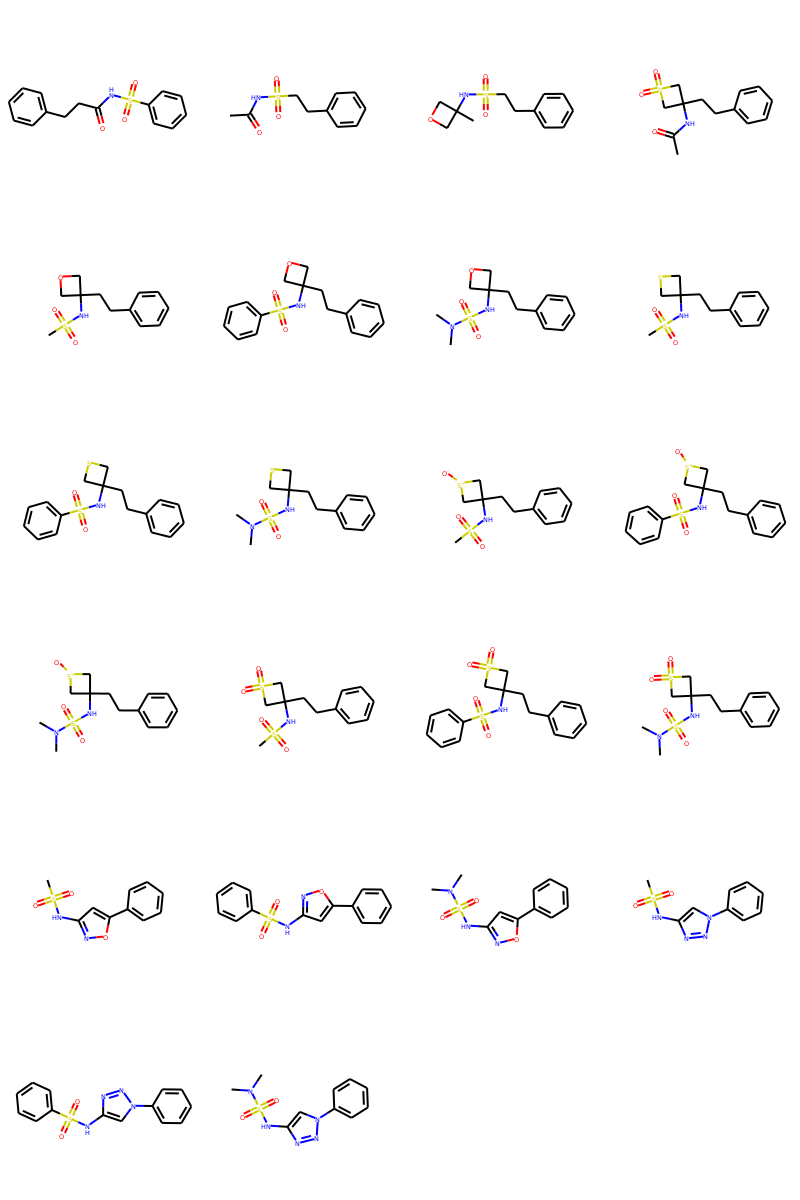

In [47]:
tmp_ms = [Chem.MolFromSmiles(x) for x in df['isomeric SMILES'].values]
Draw.MolsToGridImage(tmp_ms,molsPerRow=4,subImgSize=(200,200))

Now lets build a function that takes a list of SMILES and outputs the corresponding logP values using our previous build model:

In [31]:
def predict_logp(smiles):
    # generate desriptors
    desc_list = list(map(smiles2desc,smiles))
    Xtest = pd.DataFrame(desc_list, columns = calculator.GetDescriptorNames())
    
    # load the relevant column names
    columns = load('features.joblib')
    Xtest = Xtest[columns]
    
    # load the model
    model = load('lgbm_logp.joblib')
    ypred = model.predict(Xtest)
    return ypred
    

In [32]:
smiles = df['isomeric SMILES'].values
df['ypred'] = predict_logp(smiles)
mae = mean_absolute_error(df.logP, df['ypred'])
mse = mean_squared_error(df.logP, df['ypred'])
print("MAE: %6.2f RMSE: %6.2f" % (mae,mse**0.5)) 

MAE:   0.59 RMSE:   0.68


### Conclusions
 
 Not bad - the obtained RMSE would have been around the *3rd position* in the [SAMPL7 logP challenge](https://github.com/samplchallenges/SAMPL7/blob/master/physical_property/logP/analysis/analysis_outputs_ranked_submissions/StatisticsTables/statistics.csv).  
But also note the small dataset size (n=22) and the particular domain, i.e. mostly sulfonamids for this challenge, which of course is not sufficient to get a robust statistic for general model performance. So keep in mind having *always* a sufficiently large and representative validation set at hand.

 With a very simple setup and using a set of common python libraries we can build and deploy very accurate  QSPR like  machine learning models. Its very likely that this logP model could be improved with even more accurate data, machine learning models are data hungry, do not expect to get good results with a just hand ful of data points.    
Quite importantly, a curated dataset was used for model building, i.e. having a high noise level in the dataset usually detoriates gradient boosting regressors significantly and for such datasets more robust regressors/classifiers such as Random Forest should be used.
 
 Below some results for different runs (the score of the internal RDKit logP model with the opera dataset is RMSE=0.87 and for the SAMPL7 dataset RMSE=0.88 by the way):

|dataset|RMSE,CV|n|dataset|MAE|RMSE|n|descriptors|
|-|-|-|-|-|-|-|-|
|OPERA|0.52|10547  |SAMPL7| 0.59| 0.68 |22|RDKit MoleculeDescriptors|
|OPERA|0.50 |13962|SAMPL7| 0.66| 0.77 |22|RDKit MoleculeDescriptors|
|OPERA|0.87 |10547| SAMPL7|0.80| 1.10|22|RDKit Morgan Fingerprints|
|OPERA|0.78|13962|SAMPL7| 0.79|1.09 |22|RDKit Morgan Fingerprints|


